<div class="alert alert-block alert-success">

# Agenda 📝

We will cover:

* Order Prediction
    * EDA with respect to model building
    * Data Prep
    * Model Building
        * Linear Regression
        * Random Forest
        * Gradient Boosting 
        * XGBoost
        * Neural Networks
        * Time Series Forecasting
     
 </div>

##  <font color= darkred> Import modules and data </font>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import joblib
import os
from datetime import datetime, timedelta
from time import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')

**Load Datasets**

In [3]:
train = pd.read_csv('data/train.csv')
center = pd.read_csv('data/fulfilment_center_info.csv')
meal = pd.read_csv('data/meal_info.csv')

##  <font color= darkred> Train Data Inspection</font>🔍📊 

In [7]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [8]:
train.tail()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
456543,1271326,145,61,1543,484.09,484.09,0,0,68
456544,1062036,145,61,2304,482.09,482.09,0,0,42
456545,1110849,145,61,2664,237.68,321.07,0,0,501
456546,1147725,145,61,2569,243.50,313.34,0,0,729
456547,1361984,145,61,2490,292.03,290.03,0,0,162


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [10]:
train.describe().round(2)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00
mean,1250096.31,74.77,82.11,2024.34,332.24,354.16,0.08,0.11,261.87
std,144354.82,41.52,45.98,547.42,152.94,160.72,0.27,0.31,395.92
min,1000000.00,1.00,10.00,1062.00,2.97,55.35,0.00,0.00,13.00
25%,1124998.75,39.00,43.00,1558.00,228.95,243.50,0.00,0.00,54.00
50%,1250183.50,76.00,76.00,1993.00,296.82,310.46,0.00,0.00,136.00
75%,1375140.25,111.00,110.00,2539.00,445.23,458.87,0.00,0.00,324.00
max,1499999.00,145.00,186.00,2956.00,866.27,866.27,1.00,1.00,24299.00


* Further investigate the low checkout_price of 2.95 (looks like an outlier)
* Investigate the lowest base price 
* Investigate the high max number of orders 

In [11]:
train.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders'],
      dtype='object')

In [7]:
train_shape = train.shape
train_shape

(456548, 9)

In [13]:
train.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [14]:
train.duplicated().sum()

0

In [15]:
train.query('checkout_price < 20.00')

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
110286,1300283,38,73,1230,2.97,316.25,0,0,14


In [16]:
meal.query('meal_id == 1230')

,meal_id,category,cuisine
30,1230,Beverages,Continental


* The lowest checkout price is $2.97, for a Continental beverage, with a base price before promotions of $316.25

In [17]:
train.query('base_price < 70.00')

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
82103,1462933,29,91,1311,66.02,64.02,0,0,53
157699,1345978,53,80,1803,55.35,55.35,0,0,82
319475,1237195,104,97,1248,64.02,65.02,0,0,13
357261,1106807,115,76,1803,65.02,66.02,0,0,134


In [18]:
train.query('meal_id == 1230').sort_values('checkout_price')

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
110286,1300283,38,73,1230,2.97,316.25,0,0,14
185533,1210232,62,76,1230,173.63,464.63,0,0,15
188663,1040245,63,59,1230,173.63,466.63,0,0,15
24710,1485425,9,53,1230,175.60,351.20,0,0,26
192529,1477228,64,51,1230,175.63,466.63,0,0,13
...,...,...,...,...,...,...,...,...,...
335136,1483595,108,51,1230,515.13,514.13,0,0,15
335225,1126661,109,55,1230,515.13,513.13,0,0,13
381099,1371933,123,24,1230,515.13,514.13,0,0,67
380210,1361977,122,76,1230,515.13,513.13,0,0,41


In [19]:
train.query('meal_id == 1230 & center_id == 73').sort_values('checkout_price')

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
110286,1300283,38,73,1230,2.97,316.25,0,0,14
304592,1232120,99,73,1230,278.42,277.42,0,0,122
333816,1048113,108,73,1230,282.30,324.98,0,0,176
150442,1433126,51,73,1230,283.24,323.98,1,1,231
314407,1466541,102,73,1230,284.21,324.98,0,1,554
...,...,...,...,...,...,...,...,...,...
451852,1071772,144,73,1230,367.63,369.63,0,0,69
442022,1385193,141,73,1230,367.63,367.63,0,0,68
422321,1413825,135,73,1230,367.63,367.63,0,0,107
399284,1466188,128,73,1230,368.63,367.63,0,0,42


* Base price fluctuates significantly for meals depending on the week. However the checkout price of 2.97 must be a typo and will be corrected to $297.00
* We will ensure that this is reasonable by checking the mean of meal_id 1230 at center 73

In [20]:
meal_1230 = train.query('meal_id == 1230 & center_id == 73')
meal_1230.groupby('center_id').agg({'checkout_price': 'mean'}).sort_values('checkout_price')

,checkout_price
center_id,
73,317.568806


In [21]:
# update the checkout price for meal 1230 and center 73 on week 38 
train.loc[(train['meal_id'] == 1230) & (train['center_id'] == 73) & (train['week'] == 38)]

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
110286,1300283,38,73,1230,2.97,316.25,0,0,14


In [22]:
train.loc[(train['meal_id'] == 1230) & (train['center_id'] == 73) & (train['week'] == 38), 'checkout_price'] = 297.00

In [23]:
train.loc[(train['meal_id'] == 1230) & (train['center_id'] == 73) & (train['week'] == 38)]

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
110286,1300283,38,73,1230,297.0,316.25,0,0,14


In [24]:
train.sort_values(by = ['checkout_price', 'base_price'], ascending = [True, False])


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
44875,1381921,16,41,1248,45.62,253.23,0,0,123
44874,1414392,16,41,2631,47.59,253.23,0,0,163
417180,1372230,134,24,2631,53.41,86.39,1,0,134
72701,1324508,26,124,1803,55.35,212.43,0,0,81
55007,1149493,20,124,1803,55.35,191.09,0,0,163
...,...,...,...,...,...,...,...,...,...
429372,1373144,137,77,2867,767.33,765.33,0,0,27
429892,1313306,137,65,2867,767.33,765.33,0,0,80
430180,1055700,137,68,2444,767.33,765.33,0,0,15
430273,1432775,137,61,1445,767.33,765.33,0,0,53


In [25]:
# how many orders did each center recieve per week on average?
center_orders = train.groupby(['center_id', 'week']).agg({'num_orders': 'mean'}).reset_index()
center_orders

,center_id,week,num_orders
0,10,1,562.822222
1,10,2,479.133333
2,10,3,498.022222
3,10,4,518.045455
4,10,5,816.681818
...,...,...,...
11135,186,141,150.000000
11136,186,142,148.368421
11137,186,143,135.902439
11138,186,144,135.900000


In [26]:
# print the order average for each center across the weeks 
center_avg_orders = center_orders.groupby('center_id').agg({'num_orders': 'mean'}).sort_values('num_orders', ascending = False)
center_avg_orders

,num_orders
center_id,
13,609.869999
43,562.422545
10,482.164098
137,452.722259
52,445.864484
...,...
161,145.930590
74,131.603714
149,127.304071


In [27]:
center_avg_orders['num_orders'].mean()

253.5257300664253

* The is a large variation in number of orders per center across the weeks, from 121 - 609
* The average number of orders across all centers is 253


In [28]:
train.sort_values('num_orders', ascending= False)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
14050,1452474,5,43,2290,159.08,311.43,1,1,24299
19700,1300512,7,43,2290,159.08,311.43,1,1,15336
16904,1087163,6,43,2290,156.20,310.43,0,1,14229
13923,1470267,5,10,2290,162.99,309.43,1,0,13580
413351,1346216,132,43,1971,204.70,324.04,1,1,13150
...,...,...,...,...,...,...,...,...,...
204151,1294424,68,104,1847,243.53,243.53,0,0,13
124942,1406785,43,92,2760,232.83,232.83,0,0,13
124929,1251314,43,92,2640,280.33,282.33,0,0,13
124895,1149420,43,137,1902,447.23,446.23,0,0,13


* 2290 is the most popular meal by number of orders 

##  <font color= darkred> Meal Data Inspection</font>🔍🍴

In [33]:
meal.head()

,meal_id,category,cuisine
3,1248,Beverages,Indian
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
4,2631,Beverages,Indian


In [34]:
meal.tail()

,meal_id,category,cuisine
50,1445,Seafood,Continental
47,2104,Fish,Continental
48,2444,Seafood,Continental
49,2867,Seafood,Continental
46,2956,Fish,Continental


In [35]:
meal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   meal_id   51 non-null     int64 
 1   category  51 non-null     object
 2   cuisine   51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [69]:
meal.describe(include = 'all')

,meal_id,category,cuisine
count,51,51,51
unique,51,14,4
top,1885,Beverages,Thai
freq,1,12,15


* 4 types of cuisine, Thai being the most prevalent
* 51 unique meals
* 14 meal categories, Beverages being the most prevalent


In [43]:
meal.duplicated().sum()

0

In [44]:
meal.isnull().sum()

meal_id     0
category    0
cuisine     0
dtype: int64

* since meal_id isn't a continuous variable, we will convert it to a categorical variable

In [59]:
# change meal_id to object type 
meal['meal_id'] = meal['meal_id'].astype('object')

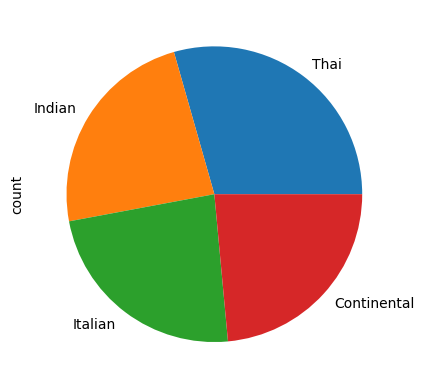

In [64]:
meal['cuisine'].value_counts().plot(kind = 'pie');

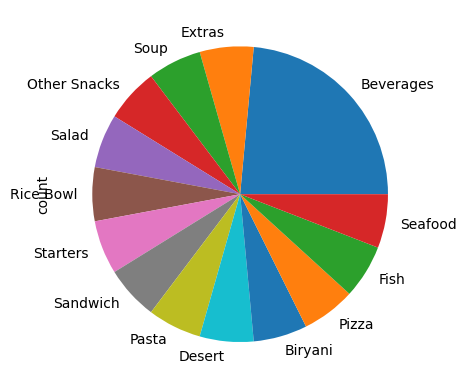

In [61]:
meal['category'].value_counts().plot(kind = 'pie');

##  <font color= darkred> Fulfillment Center Data Inspection</font>🔍🏢

In [66]:
center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [67]:
center.tail()

,center_id,city_code,region_code,center_type,op_area
72,53,590,56,TYPE_A,3.8
73,30,604,56,TYPE_A,3.5
74,76,614,85,TYPE_A,3.0
75,68,676,34,TYPE_B,4.1
76,51,638,56,TYPE_A,7.0


In [68]:
center.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   center_id    77 non-null     int64  
 1   city_code    77 non-null     int64  
 2   region_code  77 non-null     int64  
 3   center_type  77 non-null     object 
 4   op_area      77 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB


In [73]:
center.describe(include='all')

,center_id,city_code,region_code,center_type,op_area
count,77.000000,77.000000,77.000000,77,77.000000
unique,NaN,NaN,NaN,3,NaN
top,NaN,NaN,NaN,TYPE_A,NaN
freq,NaN,NaN,NaN,43,NaN
mean,83.142857,600.662338,56.493506,NaN,3.985714
std,46.090219,66.720274,18.126473,NaN,1.106406
min,10.000000,456.000000,23.000000,NaN,0.900000
25%,50.000000,553.000000,34.000000,NaN,3.500000
50%,77.000000,596.000000,56.000000,NaN,3.900000
75%,110.000000,651.000000,77.000000,NaN,4.400000


* The largest operational area for a center is 7km and smallest is 0.9km 
* Center TYPE_A is the most prelevant with 43 occurances 
* region_code can be interpreted as zip code 

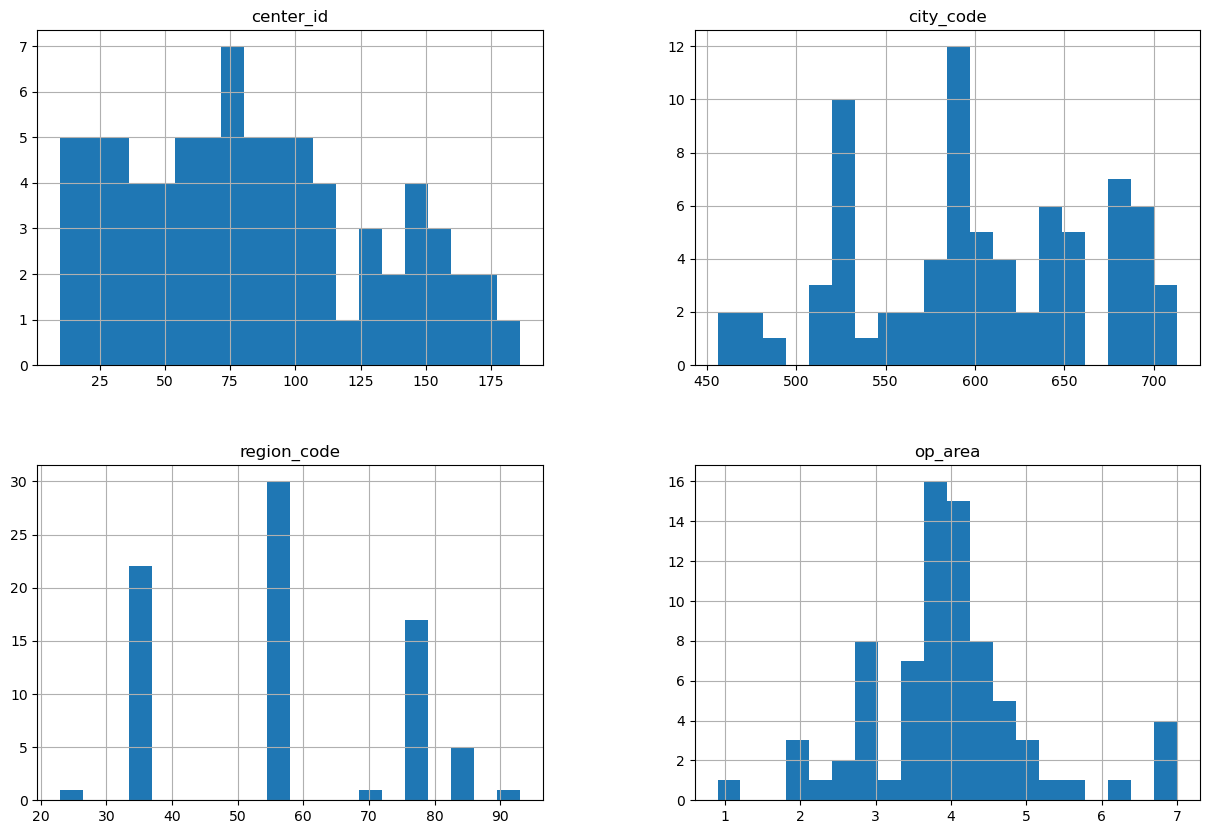

In [74]:
center.hist(figsize = (15, 10), bins = 20);

* Operational Area is the only value that has numerical significance, the others can be categorical values. 

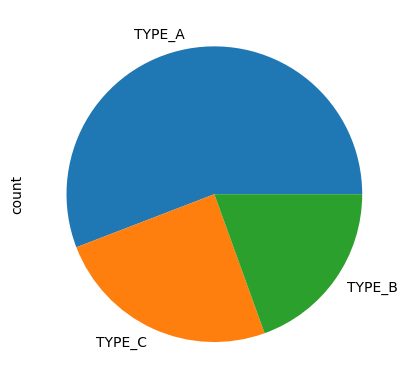

In [80]:
center['center_type'].value_counts().plot(kind = 'pie');

In [81]:
# convert center_id, region_code and city_code to object type
center['center_id'] = center['center_id'].astype('object')
center['region_code'] = center['region_code'].astype('object')
center['city_code'] = center['city_code'].astype('object')

In [82]:
center.dtypes

center_id       object
city_code       object
region_code     object
center_type     object
op_area        float64
dtype: object

##  <font color= darkred> Merge Datasets </font>

In [4]:
# convert center_id and meal_id to object type to prepare for merging 
train['center_id'] = train['center_id'].astype('object')
train['meal_id'] = train['meal_id'].astype('object')
train.dtypes

id                         int64
week                       int64
center_id                 object
meal_id                   object
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                 int64
dtype: object

In [5]:
df = train.merge(meal, on='meal_id', how='left')

In [85]:
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian


In [8]:
df = df.merge(center, on='center_id', how='left')
print('New dataset shape: ', df.shape)
print('Old dataset shape: ', train_shape)
df.head()

New dataset shape:  (456548, 19)
Old dataset shape:  (456548, 9)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code_x,region_code_x,center_type_x,op_area_x,city_code_y,region_code_y,center_type_y,op_area_y
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0,647,56,TYPE_C,2.0


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  object 
 3   meal_id                456548 non-null  object 
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   category               456548 non-null  object 
 10  cuisine                456548 non-null  object 
 11  city_code              456548 non-null  object 
 12  region_code            456548 non-null  object 
 13  center_type            456548 non-null  object 
 14  op_area                456548 non-nu

### Rename columns

In [90]:
df.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area'],
      dtype='object')

In [91]:
new_names = ['id', 'week', 'center', 'meal', 'checkout_price', 'base_price',
       'email_promo', 'homepage_featured', 'num_orders', 'meal_category',
       'cuisine', 'city', 'region', 'center_type', 'op_area']

In [92]:
df.columns = new_names # replace the existing names with new names
df.columns

Index(['id', 'week', 'center', 'meal', 'checkout_price', 'base_price',
       'email_promo', 'homepage_featured', 'num_orders', 'meal_category',
       'cuisine', 'city', 'region', 'center_type', 'op_area'],
      dtype='object')

### Create new columns

In [261]:
# create additional columns representing time and seasonality from week 

# Calculate the number of months since January 2020
df['months_since_start'] = (df['week'] - 1) // 4

# Calculate the year based on months since start
df['year'] = 2020 + df['months_since_start'] // 12

# Calculate the month based on months since start
df['month'] = df['months_since_start'] % 12 + 1

# Calculate the quarter based on the month
df['quarter'] = (df['month'] - 1) // 3 + 1

# Calculate the date for the first day of the month
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2) + '-01')

# Display a sample of the DataFrame to check the calculations
print(df[['week', 'months_since_start', 'year', 'month', 'quarter', 'date']].sample(5))

# Now you can filter and check data for each quarter in 2023
df_2023 = df[df['year'] == 2023]

# Loop through each quarter and print the data
for quarter in range(1, 5):
    df_2023_quarter = df_2023[df_2023['quarter'] == quarter]
    print(f"Data for 2023 Quarter {quarter}:")
    print("\n")
    df_2023_quarter


        week  months_since_start  year  month  quarter       date
239790    79                  19  2021      8        3 2021-08-01
258069    85                  21  2021     10        4 2021-10-01
222747    74                  18  2021      7        3 2021-07-01
123096    42                  10  2020     11        4 2020-11-01
381289   123                  30  2022      7        3 2022-07-01
Data for 2023 Quarter 1:
        week  checkout_price  base_price  discount  discount_percent  \
453280   145          156.23      156.23      0.00          0.000000   
453281   145          159.14      158.14      0.00          0.000000   
453282   145          158.11      160.11      2.00          1.249141   
453283   145          292.03      292.03      0.00          0.000000   
453284   145          165.93      165.93      0.00          0.000000   
...      ...             ...         ...       ...               ...   
456543   145          484.09      484.09      0.00          0.000000   
456

In [262]:
for quarter in range(1, 5):
    df_2023_quarter = df_2023[df_2023['quarter'] == quarter]
    print(f"Data for 2023 Quarter {quarter}:")
    print("\n")
    df_2023_quarter

Data for 2023 Quarter 1:


Data for 2023 Quarter 2:


Data for 2023 Quarter 3:


Data for 2023 Quarter 4:




In [265]:
months_distribution = df.groupby(['year', 'quarter'])['month'].unique().reset_index()
print("Distribution of months across quarters and years:")
months_distribution.head(20)

Distribution of months across quarters and years:


,year,quarter,month
0,2020,1,"[1, 2, 3]"
1,2020,2,"[4, 5, 6]"
2,2020,3,"[7, 8, 9]"
3,2020,4,"[10, 11, 12]"
4,2021,1,"[1, 2, 3]"
5,2021,2,"[4, 5, 6]"
6,2021,3,"[7, 8, 9]"
7,2021,4,"[10, 11, 12]"
8,2022,1,"[1, 2, 3]"
9,2022,2,"[4, 5, 6]"


In [268]:
# Check for any missing months in the expected range
all_months = set(range(1, 13))
for year in df['year'].unique():
    for quarter in range(1, 5):
        months_in_quarter = set(df[(df['year'] == year) & (df['quarter'] == quarter)]['month'])
        missing_months = all_months - months_in_quarter
        if missing_months:
            print(f"Missing months in Year {year} Quarter {quarter}: {missing_months}")

# Summary statistics for each year and quarter
summary_stats = df.groupby(['year', 'quarter'])['month'].agg(['count', 'min', 'max']).reset_index()
print("Summary statistics for each year and quarter:")
summary_stats.head(20)

Missing months in Year 2020 Quarter 1: {4, 5, 6, 7, 8, 9, 10, 11, 12}
Missing months in Year 2020 Quarter 2: {1, 2, 3, 7, 8, 9, 10, 11, 12}
Missing months in Year 2020 Quarter 3: {1, 2, 3, 4, 5, 6, 10, 11, 12}
Missing months in Year 2020 Quarter 4: {1, 2, 3, 4, 5, 6, 7, 8, 9}
Missing months in Year 2021 Quarter 1: {4, 5, 6, 7, 8, 9, 10, 11, 12}
Missing months in Year 2021 Quarter 2: {1, 2, 3, 7, 8, 9, 10, 11, 12}
Missing months in Year 2021 Quarter 3: {1, 2, 3, 4, 5, 6, 10, 11, 12}
Missing months in Year 2021 Quarter 4: {1, 2, 3, 4, 5, 6, 7, 8, 9}
Missing months in Year 2022 Quarter 1: {4, 5, 6, 7, 8, 9, 10, 11, 12}
Missing months in Year 2022 Quarter 2: {1, 2, 3, 7, 8, 9, 10, 11, 12}
Missing months in Year 2022 Quarter 3: {1, 2, 3, 4, 5, 6, 10, 11, 12}
Missing months in Year 2022 Quarter 4: {1, 2, 3, 4, 5, 6, 7, 8, 9}
Missing months in Year 2023 Quarter 1: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Missing months in Year 2023 Quarter 2: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Missing months

,year,quarter,count,min,max
0,2020,1,34299,1,3
1,2020,2,34891,4,6
2,2020,3,36393,7,9
3,2020,4,36868,10,12
4,2021,1,37728,1,3
5,2021,2,38230,4,6
6,2021,3,38677,7,9
7,2021,4,39145,10,12
8,2022,1,38984,1,3
9,2022,2,39183,4,6


In [266]:
df.tail() # dataset includes up until 2023-01-01

,week,checkout_price,base_price,discount,discount_percent,email_promo,homepage_featured,meal,meal_category,cuisine,...,region,center,center_type,op_area,year,quarter,month,date,num_orders,months_since_start
456543,145,484.09,484.09,0.00,0.000000,0,0,1543,Desert,Indian,...,77,61,TYPE_A,4.5,2023,1,1,2023-01-01,68,36
456544,145,482.09,482.09,0.00,0.000000,0,0,2304,Desert,Indian,...,77,61,TYPE_A,4.5,2023,1,1,2023-01-01,42,36
456545,145,237.68,321.07,83.39,25.972529,0,0,2664,Salad,Italian,...,77,61,TYPE_A,4.5,2023,1,1,2023-01-01,501,36
456546,145,243.50,313.34,69.84,22.288887,0,0,2569,Salad,Italian,...,77,61,TYPE_A,4.5,2023,1,1,2023-01-01,729,36
456547,145,292.03,290.03,0.00,0.000000,0,0,2490,Salad,Italian,...,77,61,TYPE_A,4.5,2023,1,1,2023-01-01,162,36


In [185]:
# add discount and discount percent columns 
df['discount'] = df['base_price'] - df['checkout_price']
df['discount'] = df['discount'].apply(lambda x: x if x > 0 else 0)

df['discount_percent'] = (df['discount'] / df['base_price']) * 100
df['discount_percent'] = df['discount_percent'].replace([float('inf'), -float('inf')], 0).fillna(0)
df[['base_price', 'checkout_price', 'discount', 'discount_percent']].sample(5)

,base_price,checkout_price,discount,discount_percent
290588,472.39,474.39,0.0,0.000000
334836,283.30,283.30,0.0,0.000000
425216,154.23,155.23,0.0,0.000000
44168,146.53,145.53,1.0,0.682454
42236,282.33,280.33,2.0,0.708391


### Drop Columns 

In [11]:
df.columns

Index(['week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'category',
       'cuisine', 'city_code_x', 'region_code_x', 'center_type_x', 'op_area_x',
       'city_code_y', 'region_code_y', 'center_type_y', 'op_area_y'],
      dtype='object')

In [9]:
df.drop(columns = ['id'], inplace = True)

### Reorder columns

In [190]:
# move the target column to the last position 
df = df[['week', 'checkout_price', 'base_price','discount','discount_percent', 
       'email_promo', 'homepage_featured', 'meal', 'meal_category', 'cuisine', 'city',
       'region', 'center', 'center_type', 'op_area', 'year',
       'quarter', 'month', 'date', 'num_orders']]
df.head()

,week,checkout_price,base_price,discount,discount_percent,email_promo,homepage_featured,meal,meal_category,cuisine,city,region,center,center_type,op_area,year,quarter,month,date,num_orders
0,1,136.83,152.29,15.46,10.151684,0,0,1885,Beverages,Thai,647,56,55,TYPE_C,2.0,2020,1,1,2020-01-01,177
1,1,136.83,135.83,0.00,0.000000,0,0,1993,Beverages,Thai,647,56,55,TYPE_C,2.0,2020,1,1,2020-01-01,270
2,1,134.86,135.86,1.00,0.736052,0,0,2539,Beverages,Thai,647,56,55,TYPE_C,2.0,2020,1,1,2020-01-01,189
3,1,339.50,437.53,98.03,22.405321,0,0,2139,Beverages,Indian,647,56,55,TYPE_C,2.0,2020,1,1,2020-01-01,54
4,1,243.50,242.50,0.00,0.000000,0,0,2631,Beverages,Indian,647,56,55,TYPE_C,2.0,2020,1,1,2020-01-01,40


### Change datatypes

In [203]:
df.dtypes

week                          int64
checkout_price              float64
base_price                  float64
discount                    float64
discount_percent            float64
email_promo                   int64
homepage_featured             int64
meal                         object
meal_category                object
cuisine                      object
city                         object
region                       object
center                       object
center_type                  object
op_area                     float64
year                          int64
quarter                       int64
month                         int64
date                 datetime64[ns]
num_orders                    int64
dtype: object

### Save new Dataframe to csv 

In [192]:
# save df to csv 
df.to_csv('df.csv', index = False)

##   <font color= darkred> EDA </font>

### <font color= darkred> Numerical inspection and summaries </font>

In [193]:
df.describe(include= 'all').round(2)

,week,checkout_price,base_price,discount,discount_percent,email_promo,homepage_featured,meal,meal_category,cuisine,city,region,center,center_type,op_area,year,quarter,month,date,num_orders
count,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.0,456548,456548,456548.0,456548.0,456548.0,456548,456548.00,456548.00,456548.00,456548.00,456548,456548.00
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,14,4,51.0,8.0,77.0,3,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2290.0,Beverages,Italian,590.0,56.0,13.0,TYPE_A,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11138.0,127890,122925,54746.0,191228.0,7046.0,262881,NaN,NaN,NaN,NaN,NaN,NaN
mean,74.77,332.24,354.16,22.39,5.90,0.08,0.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.08,2021.05,2.58,6.51,2021-07-03 18:58:26.354644224,261.87
min,1.00,45.62,55.35,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.90,2020.00,1.00,1.00,2020-01-01 00:00:00,13.00
25%,39.00,228.95,243.50,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.60,2020.00,2.00,3.00,2020-10-01 00:00:00,54.00
50%,76.00,296.82,310.46,1.00,0.14,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,2021.00,3.00,7.00,2021-07-01 00:00:00,136.00
75%,111.00,445.23,458.87,16.52,6.24,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.50,2022.00,4.00,10.00,2022-04-01 00:00:00,324.00
max,145.00,866.27,866.27,561.60,82.37,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.00,2023.00,5.00,12.00,2023-01-01 00:00:00,24299.00


In [362]:
df.describe()

,week,checkout_price,base_price,discount,discount_percent,email_promo,homepage_featured,op_area,year,quarter,month,date,num_orders,months_since_start
count,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000,456548.000000,456548.000000,456548.000000,456548,456548.000000,456548.000000
mean,74.768771,332.239577,354.156627,22.388699,5.895378,0.081152,0.10920,4.083590,2021.046291,2.506337,6.514463,2021-07-03 18:58:26.354644224,261.872760,18.069953
min,1.000000,45.620000,55.350000,0.000000,0.000000,0.000000,0.00000,0.900000,2020.000000,1.000000,1.000000,2020-01-01 00:00:00,13.000000,0.000000
25%,39.000000,228.950000,243.500000,0.000000,0.000000,0.000000,0.00000,3.600000,2020.000000,1.000000,3.000000,2020-10-01 00:00:00,54.000000,9.000000
50%,76.000000,296.820000,310.460000,1.000000,0.141217,0.000000,0.00000,4.000000,2021.000000,3.000000,7.000000,2021-07-01 00:00:00,136.000000,18.000000
75%,111.000000,445.230000,458.870000,16.520000,6.239530,0.000000,0.00000,4.500000,2022.000000,4.000000,10.000000,2022-04-01 00:00:00,324.000000,27.000000
max,145.000000,866.270000,866.270000,561.600000,82.370821,1.000000,1.00000,7.000000,2023.000000,4.000000,12.000000,2023-01-01 00:00:00,24299.000000,36.000000
std,41.524956,152.938956,160.715914,48.214009,11.231763,0.273069,0.31189,1.091686,0.826136,1.120925,3.469822,NaN,395.922798,10.382406


### Numerical Features 

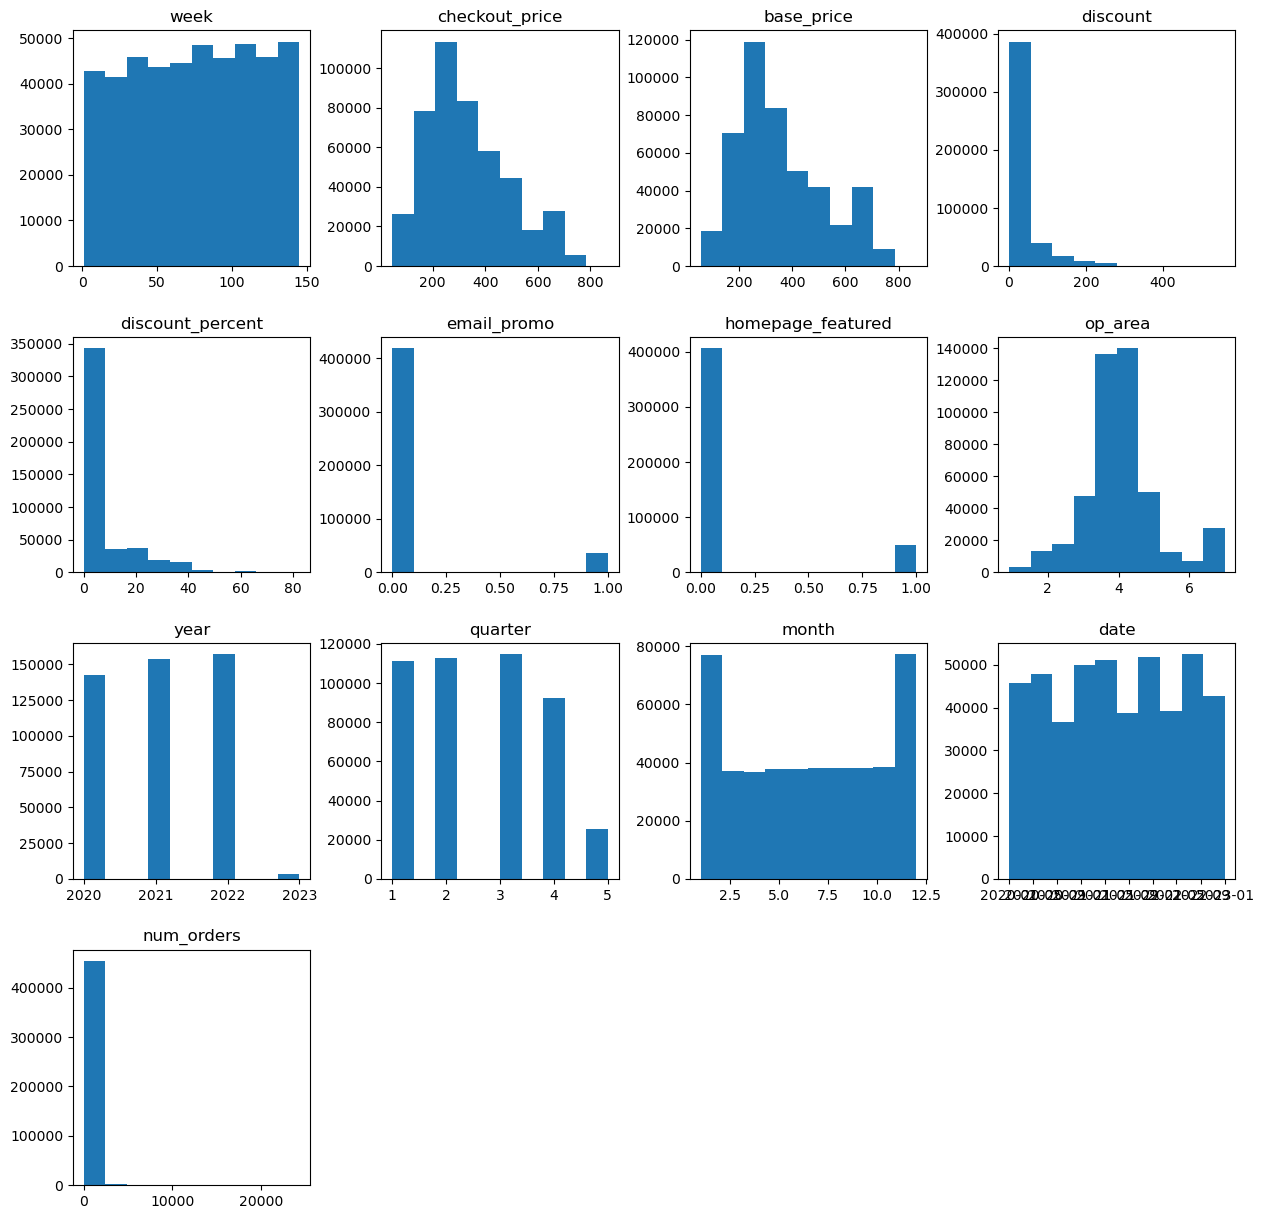

In [196]:
df.hist(figsize = (15, 15), grid = False);

### Categorical Features 

### Seasonality

Text(0.5, 0.98, 'Number of orders decrease slightly from 2020 onwards, 2023 is not a full year')

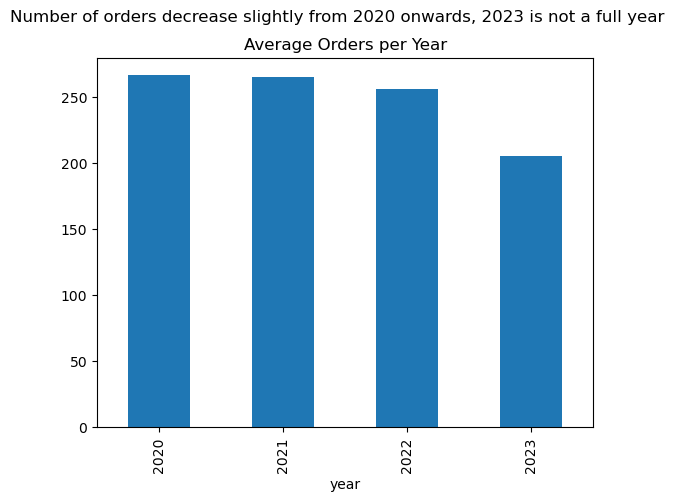

In [157]:
df.groupby('year')['num_orders'].mean().plot(kind = 'bar');
plt.title('Average Orders per Year')
plt.suptitle('Number of orders decrease slightly from 2020 onwards, 2023 is not a full year')

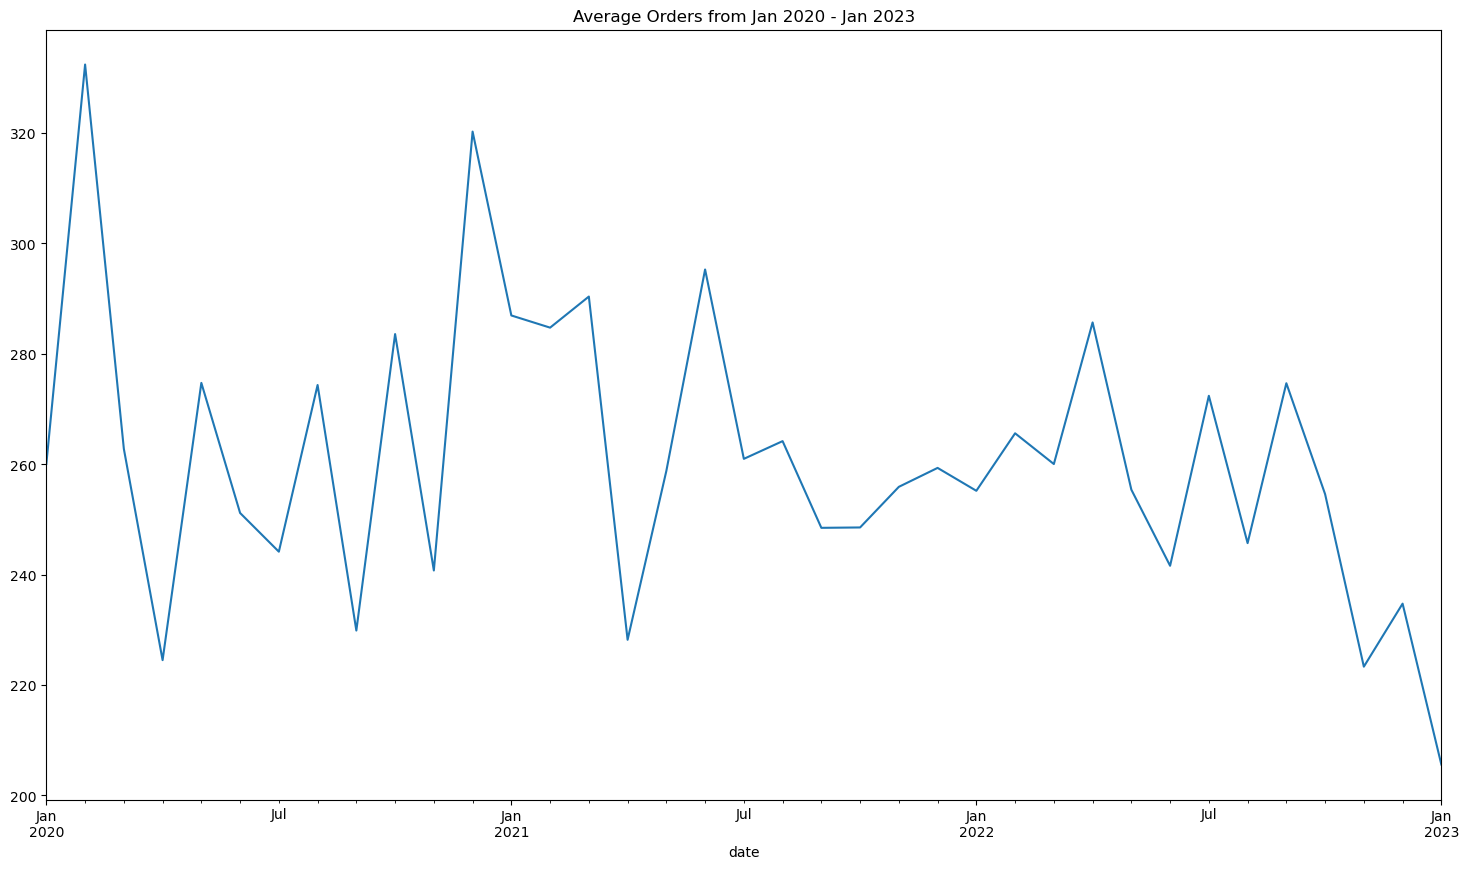

In [161]:
plt.figure(figsize = (18, 10))
df.groupby(['date'])['num_orders'].mean().plot(kind = 'line')
plt.title('Average Orders from Jan 2020 - Jan 2023');

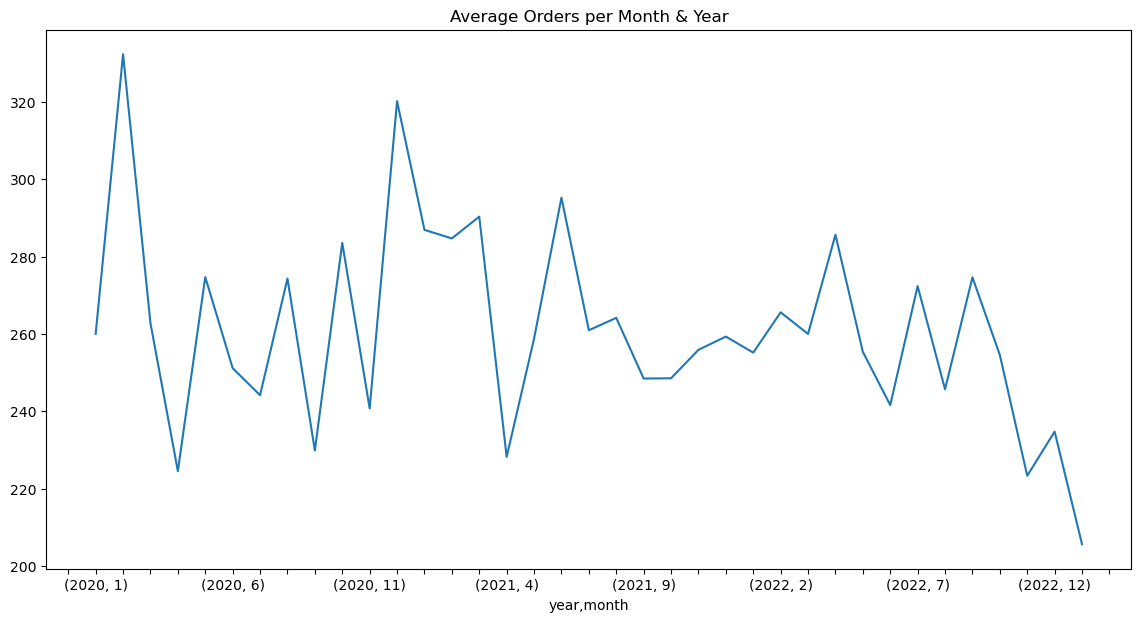

In [344]:
plt.figure(figsize = (18, 10))
df.groupby(['year','month'])['num_orders'].mean().plot(kind = 'line', title = 'Average Orders per Month & Year', figsize = (14, 7));
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

In [332]:
monthly = df.groupby(['year', 'month'], as_index = False)['num_orders'].mean()
monthly.tail()

,year,month,num_orders
32,2022,9,274.661305
33,2022,10,254.578708
34,2022,11,223.330322
35,2022,12,234.743973
36,2023,1,205.607711


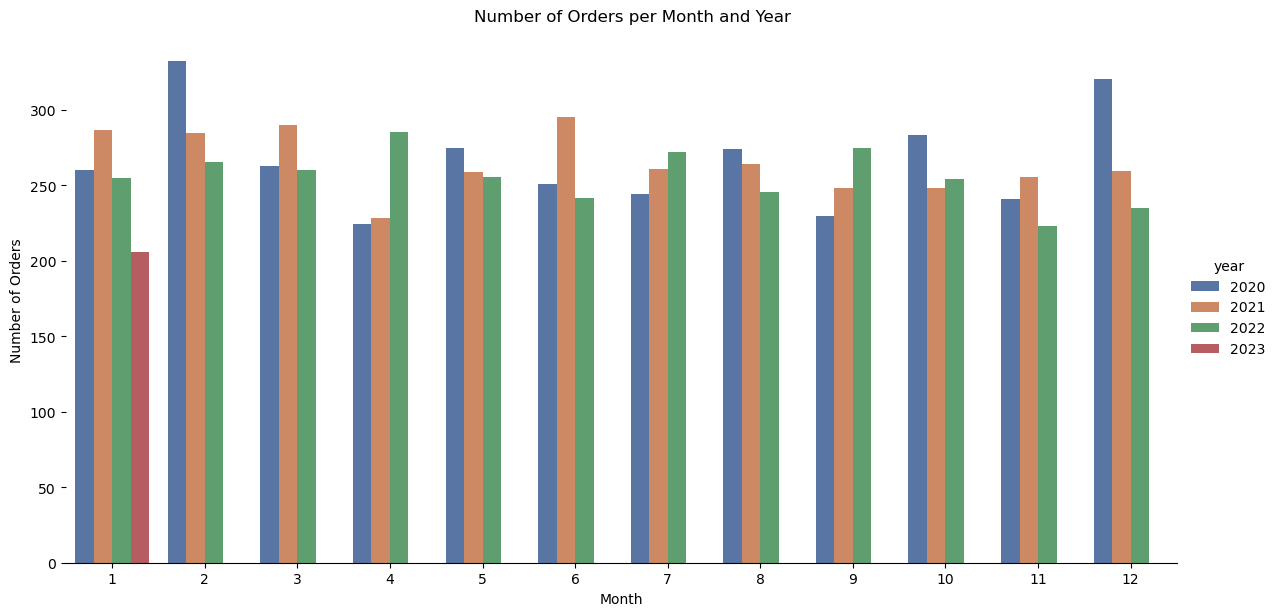

In [341]:
g = sns.catplot(
    data=monthly,
    x='month', y='num_orders', hue='year',
    kind='bar', height=6, aspect=2,
    palette='deep'
)
g.set_axis_labels('Month', 'Number of Orders')
g.set_titles('Number of Orders per Month and Year')
g.despine(left=True)
g.fig.suptitle('Average Order Quantity per Month and Year', y=1.02)  # Adjust suptitle position
plt.show()


Text(0, 0.5, 'Number of Orders')

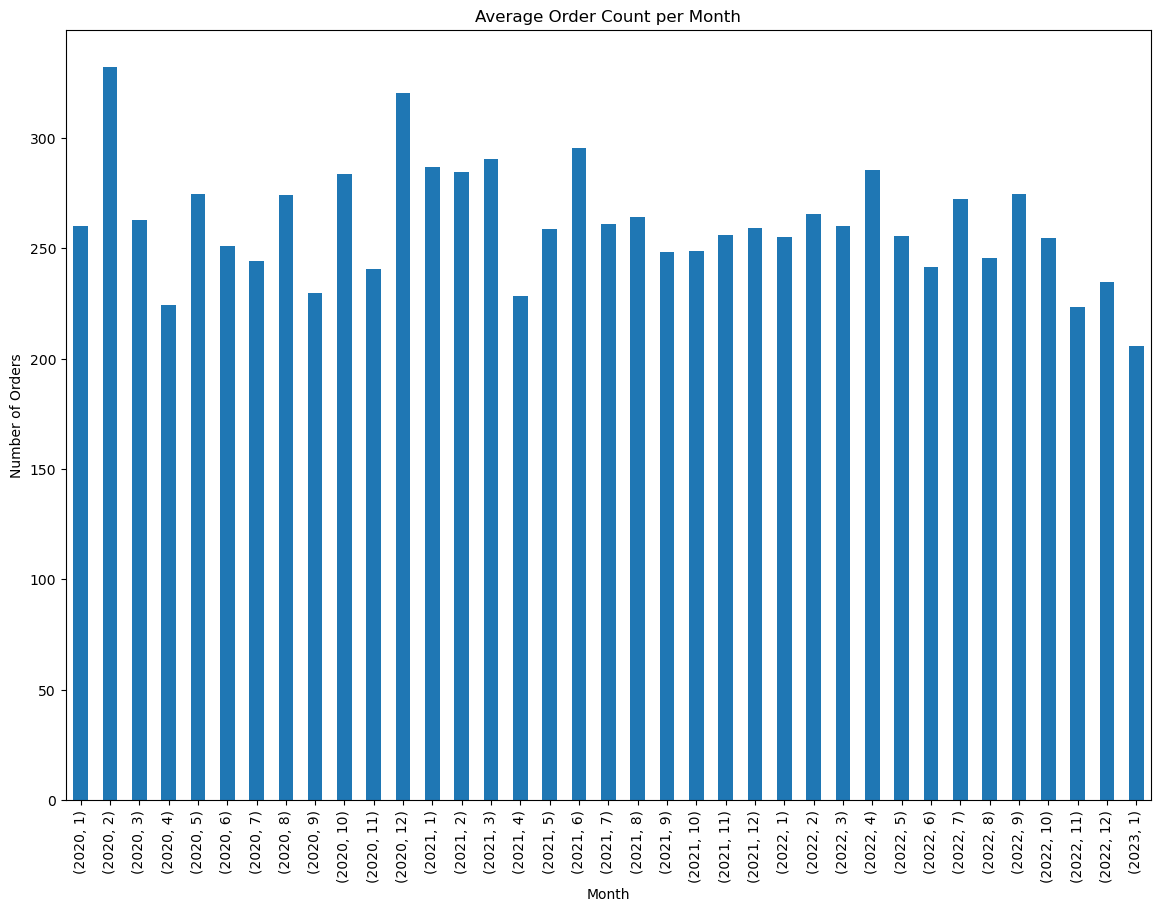

In [342]:
fig = plt.subplots(figsize=(14, 10))
df.groupby(['year','month'])['num_orders'].mean().plot(kind = 'bar');
plt.title('Average Order Count per Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')

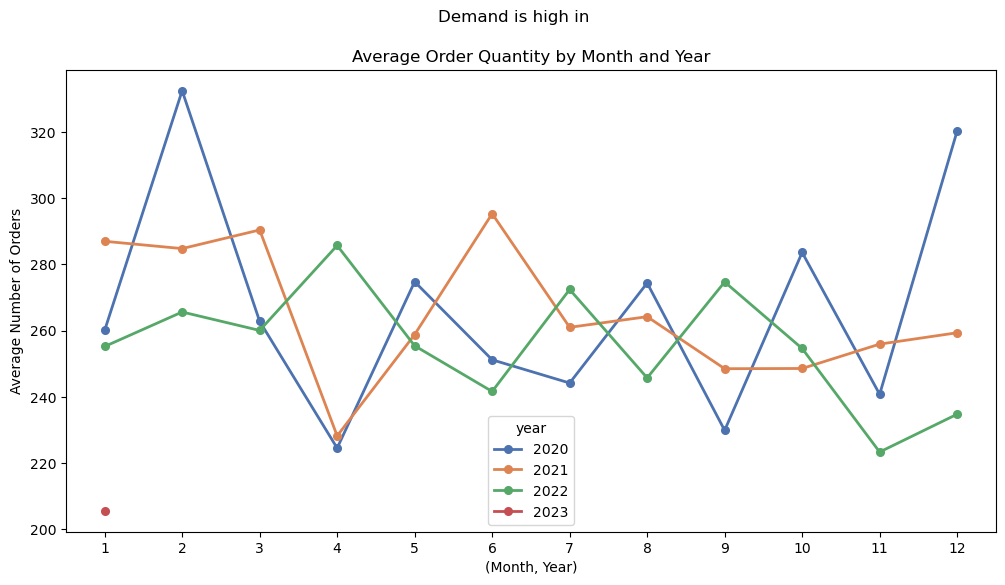

In [339]:
fig = plt.subplots(figsize=(12, 6))
ax = sns.pointplot(data = monthly, x = 'month', y = 'num_orders', hue = 'year', palette='deep', linewidth =2 ).set(xlabel = '(Month, Year)', ylabel = 'Average Number of Orders', title = 'Average Order Quantity by Month and Year')
plt.suptitle("Demand is high in ")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

In [329]:
quarterly = df.groupby(['year', 'quarter'], as_index = False)['num_orders'].mean()
quarterly.tail()

,year,quarter,num_orders
8,2022,1,260.220347
9,2022,2,260.813465
10,2022,3,264.320013
11,2022,4,237.562456
12,2023,1,205.607711


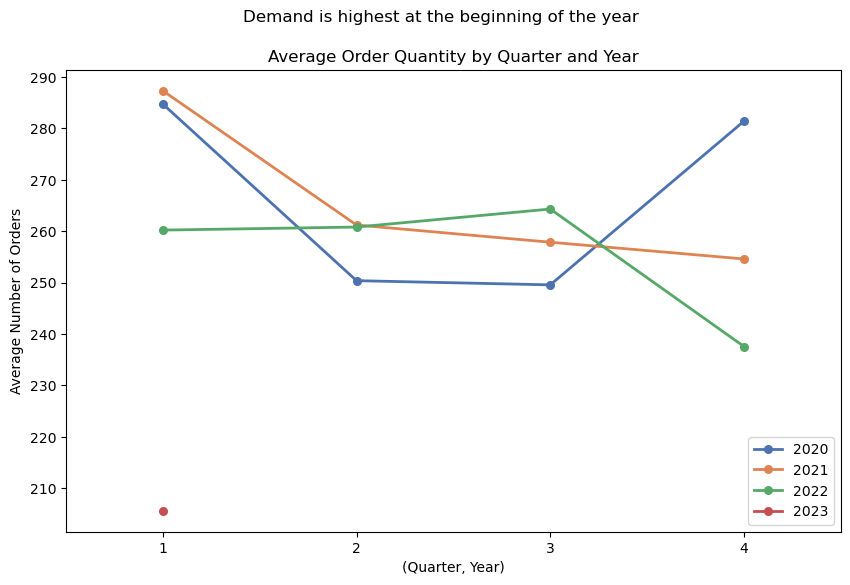

In [331]:
plt.figure(figsize=(10, 6))
ax = sns.pointplot(data=quarterly, x='quarter', y='num_orders', hue='year', palette='deep', linewidth=2)
ax.legend(loc='lower right')
ax.set_xlabel('(Quarter, Year)')
ax.set_ylabel('Average Number of Orders')
ax.set_title('Average Order Quantity by Quarter and Year')
plt.suptitle('Demand is highest at the beginning of the year')
plt.show()

* Spike in the number of orders in Januray
* Quarterly Plot shows us spikes in Q1, Q4 and Q5 and a low in Q2 and Q3

In [278]:
monthly_cuisine = df.groupby(['year', 'month', 'cuisine'], as_index=False)['num_orders'].mean()
monthly_cuisine.head()

,year,month,cuisine,num_orders
0,2020,1,Continental,200.560000
1,2020,1,Indian,205.309925
2,2020,1,Italian,307.962116
3,2020,1,Thai,319.812941
4,2020,2,Continental,139.855750


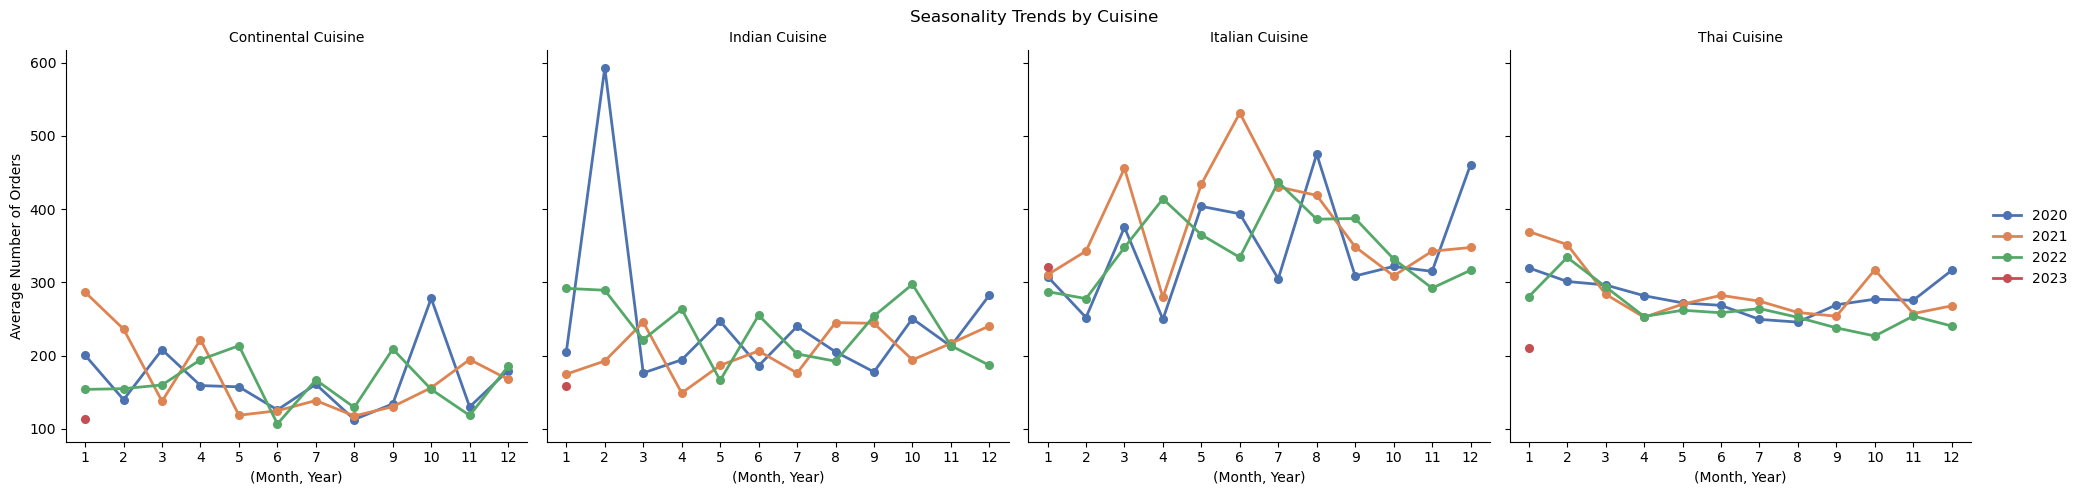

In [309]:
g = sns.FacetGrid(monthly_cuisine, col="cuisine", col_wrap=4, height=5, sharey=True)
g.map(sns.pointplot, 'month', 'num_orders', 'year', palette='deep', linewidth=2)
g.add_legend()
g.set_axis_labels('(Month, Year)', 'Average Number of Orders')
g.set_titles(col_template='{col_name} Cuisine')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Seasonality Trends by Cuisine')
plt.savefig('seasonality_cuisine.png')
plt.show()

In [355]:
monthly_category = df.groupby(['year', 'month', 'meal_category'], as_index=False)['num_orders'].mean()
monthly_category.head()

,year,month,meal_category,num_orders
0,2020,1,Beverages,390.463408
1,2020,1,Biryani,42.742378
2,2020,1,Desert,60.976773
3,2020,1,Extras,341.811170
4,2020,1,Other Snacks,181.137626


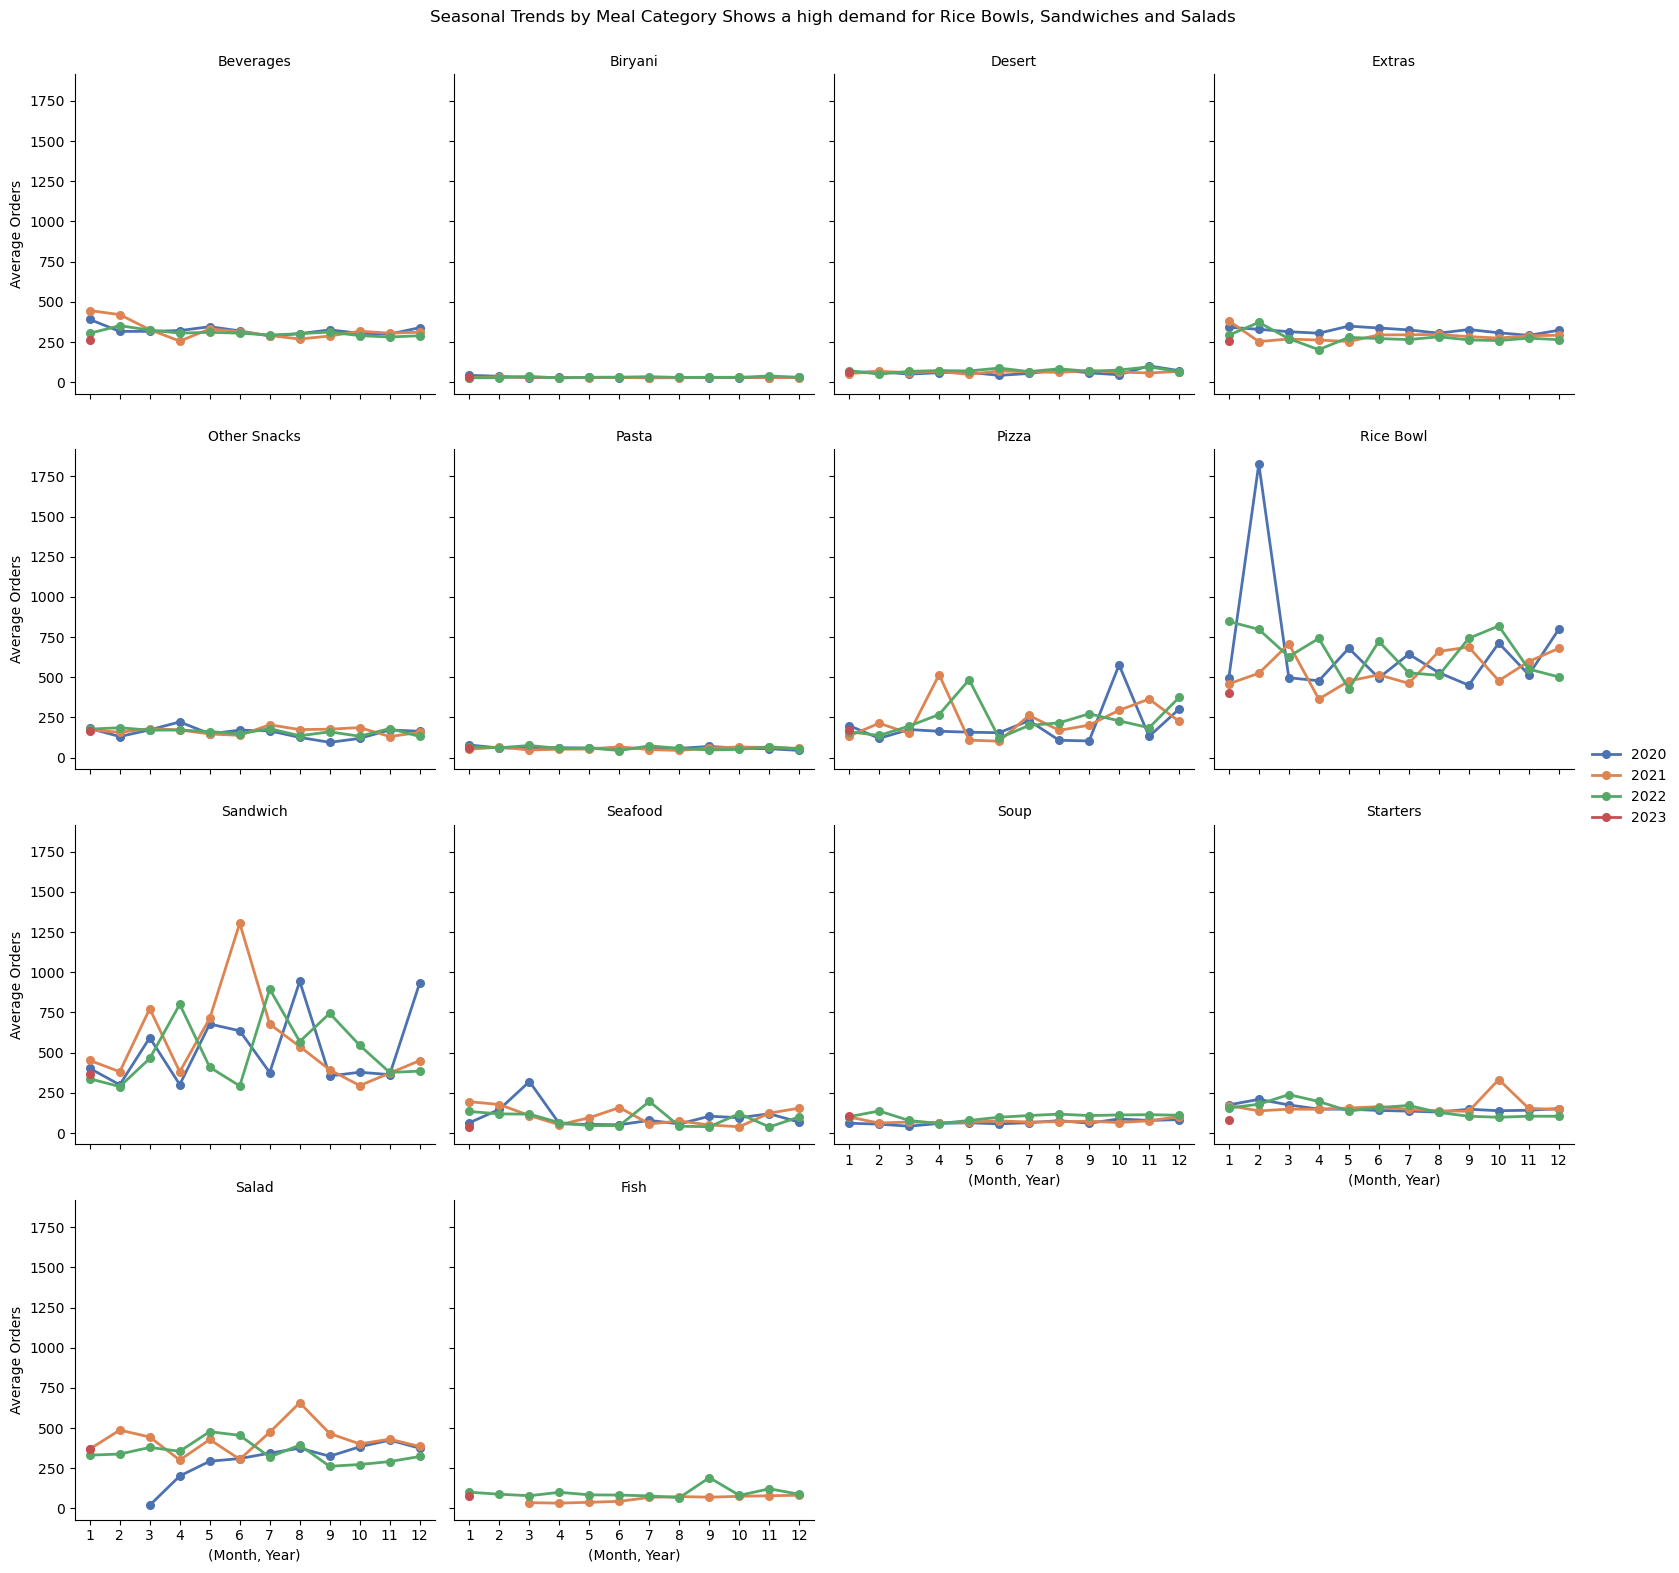

In [361]:
palette = sns.color_palette("deep", n_colors=4)
year_palette = {2020: palette[0], 2021: palette[1], 2022: palette[2], 2023: palette[3]}

g = sns.FacetGrid(monthly_category, col="meal_category", col_wrap=4, height=4, sharey=True)
g.map(sns.pointplot, 'month', 'num_orders', 'year', palette=year_palette, linewidth=2)
g.add_legend()
g.set_axis_labels('(Month, Year)', 'Average Orders')
g.set_titles(col_template='{col_name}')
plt.subplots_adjust(top=0.94)
g.fig.suptitle('Seasonal Trends by Meal Category Shows a high demand for Rice Bowls, Sandwiches and Salads')

plt.show()

### Correlation

#### Bivariate Analysis

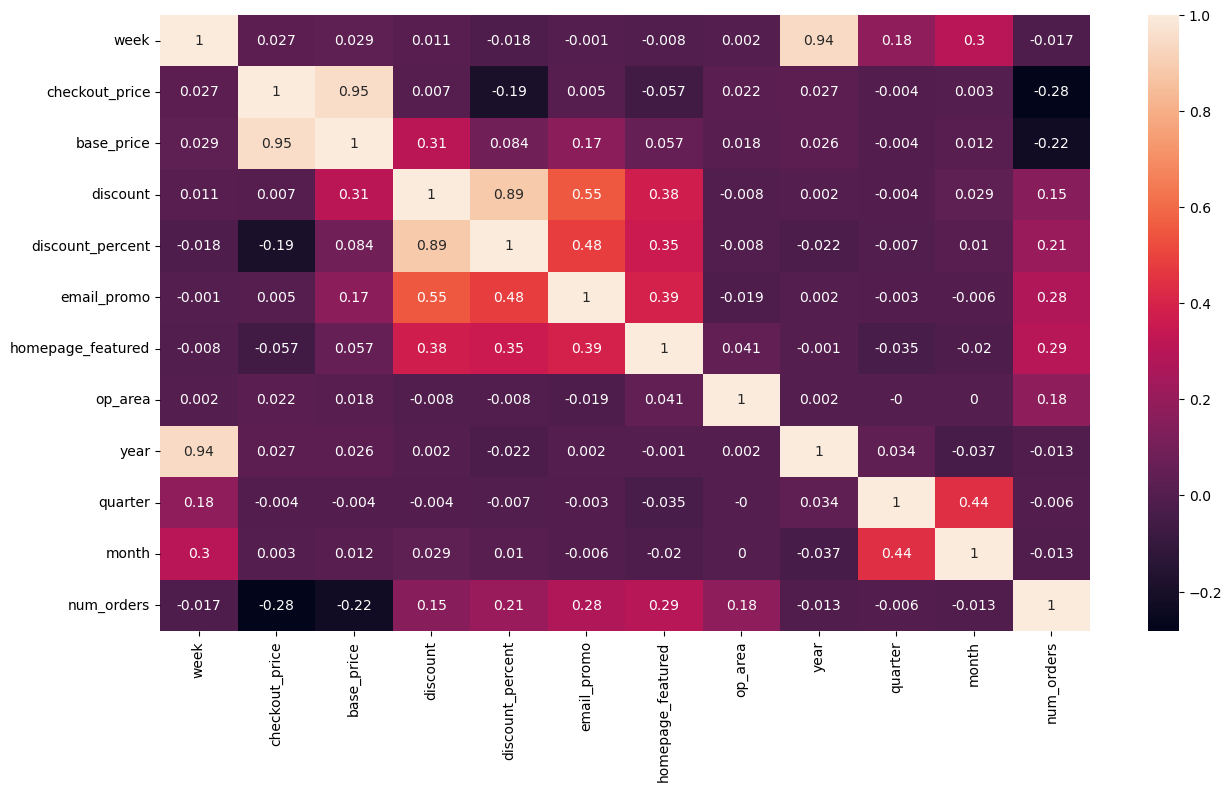

In [199]:
corr = df.corr(numeric_only = True).round(3)
plt.figure(figsize= (15,8))
sns.heatmap(corr, annot= True);

* `order_num` have a slight positive correlation with homepage featured and email promo, meaning that marketing increases number of orders
* `order_num` also has a positive correlation with discount percent which shows as discount percent goes up, number of orders goes up aswell. 
* `order_num` has a negative correlation with checkout price and base price, as the price increases the number of orders decreases

##  <font color= darkred> Prep for Modeling </font>

In [391]:
results = []
feature_importances = {}

In [392]:
# set up dataframes for storing results
models = {
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Neural Network": MLPRegressor(max_iter=1000), 
    "Random Forest": RandomForestRegressor()
}

In [393]:
params = {
    "Gradient Boosting": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    "XGBoost": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    "Decision Tree": {
        'model__max_depth': [3, 5, 10],
        'model__min_samples_split': [2, 10, 20]
    },
    "Neural Network": {
        'model__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'model__activation': ['tanh', 'relu'],
        'model__solver': ['sgd', 'adam'],
        'model__alpha': [0.0001, 0.05],
        'model__learning_rate': ['constant','adaptive'],
    }, 
    "Random Forest": {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 10],
    'model__min_samples_split': [2, 10, 20]
    }
}

### Include baseline model

##  <font color= darkred> Modeling </font>

In [405]:
def evaluate_models(df, target_col, numerical_features, categorical_features):

    # print system time to track duration of the process
    print(datetime.now())

    X = df.drop(columns=[target_col])
    y = df[target_col]

    # For non-time series models, regular split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # For time series models, split based on week number
    df_sorted = df.sort_values(by='week')
    X_ts_train = df_sorted[df_sorted['week'] <= df_sorted['week'].quantile(0.6)]
    X_ts_temp = df_sorted[df_sorted['week'] > df_sorted['week'].quantile(0.6)]
    X_ts_val = X_ts_temp[X_ts_temp['week'] <= df_sorted['week'].quantile(0.8)]
    X_ts_test = X_ts_temp[X_ts_temp['week'] > df_sorted['week'].quantile(0.8)]

    y_ts_train = X_ts_train[target_col]
    y_ts_val = X_ts_val[target_col]
    y_ts_test = X_ts_test[target_col]

    # Drop target column for features
    X_ts_train = X_ts_train.drop(columns=[target_col])
    X_ts_val = X_ts_val.drop(columns=[target_col])
    X_ts_test = X_ts_test.drop(columns=[target_col])
    
    if df[target_col].min() < 0:
        raise ValueError("Negative values found in target variable.")

    # Preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ])

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        grid_search_time, fit_time, best_model = None, None, model

        if model_name in params:
            pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('model', model)])
            start_time = time()
            grid_search = RandomizedSearchCV(pipeline, params[model_name], scoring='neg_mean_squared_log_error', cv=3, n_iter=10, verbose=3, random_state=42)
            grid_search.fit(X_train, y_train)
            grid_search_time = (time() - start_time) / 60
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best score: {grid_search.best_score_}")
            print(f"Best estimator: {grid_search.best_estimator_}")
            print(f"Time taken for {model_name} grid search: {grid_search_time:.2f} minutes")

            best_model = grid_search.best_estimator_

            start_time = time()
            best_model.fit(X_train, y_train)
            fit_time = (time() - start_time) / 60 
            print(f"Time taken for {model_name} fitting: {fit_time:.2f} minutes")
        else:
            pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('model', model)])
            start_time = time()
            pipeline.fit(X_train, y_train)
            fit_time = (time() - start_time) / 60 
            print(f"Time taken for {model_name} fitting: {fit_time:.2f} minutes")
            best_model = pipeline

        # Save the trained model
        joblib.dump(best_model, f"{model_name}_best_model.pkl")

        # Predictions for train and validation sets
        train_predictions = best_model.predict(X_train)
        val_predictions = best_model.predict(X_val)

        # Debug: Check predictions for negative values
        negative_train_predictions = train_predictions[train_predictions < 0]
        negative_val_predictions = val_predictions[val_predictions < 0]
        if len(negative_train_predictions) > 0 or len(negative_val_predictions) > 0:
            print(f"Negative predictions found for model {model_name}")
            if len(negative_train_predictions) > 0:
                print(f"Negative train predictions: {negative_train_predictions}")
            if len(negative_val_predictions) > 0:
                print(f"Negative validation predictions: {negative_val_predictions}")

            # Clip predictions to ensure non-negative values
            train_predictions = np.clip(train_predictions, 0, None)
            val_predictions = np.clip(val_predictions, 0, None)
        
    
        train_rmsle = np.sqrt(mean_squared_log_error(y_train, train_predictions))
        val_rmsle = np.sqrt(mean_squared_log_error(y_val, val_predictions))
        print(f"Train RMSLE: {train_rmsle:.4f}")
        print(f"Validation RMSLE: {val_rmsle:.4f}")

        results.append({
            "Model": model_name,
            "Train RMSLE": 100 * train_rmsle,
            "Validation RMSLE": 100 * val_rmsle,
            "Grid Search Time (s)": grid_search_time,
            "Fit Time (s)": fit_time,
            "Best Params": best_model.get_params() if model_name in params else "N/A"
        })

        perm_importance = permutation_importance(best_model['model'], preprocessor.transform(X_val), y_val, n_repeats=10, random_state=42)
        importance_df = pd.DataFrame({
            'Feature': list(preprocessor.transformers_[0][2]) + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)),
            'Importance': perm_importance.importances_mean
        }).sort_values(by='Importance', ascending=False)

        feature_importances[model_name] = importance_df  # Save the feature importances to the dictionary
        
        top_features = importance_df.head(20)
        print(top_features)
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title(f'Permutation Importance for {model_name}')
        plt.show()

    # Time series model using XGBoost
    ts_model = xgb.XGBRegressor()
    ts_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', ts_model)])
    start_time = time()
    ts_pipeline.fit(X_ts_train, y_ts_train)
    fit_time = (time() - start_time) / 60 
    print(f"Time taken for Time Series XGBoost fitting: {fit_time:.2f} minutes")

    negative_train_predictions = train_predictions[train_predictions < 0]
    negative_val_predictions = val_predictions[val_predictions < 0]
    if len(negative_train_predictions) > 0 or len(negative_val_predictions) > 0:
        print("Negative predictions found for Time Series XGBoost")
        if len(negative_train_predictions) > 0:
            print(f"Negative train predictions: {negative_train_predictions}")
        if len(negative_val_predictions) > 0:
            print(f"Negative validation predictions: {negative_val_predictions}")

    train_predictions = ts_pipeline.predict(X_ts_train)
    val_predictions = ts_pipeline.predict(X_ts_val)
    
    # Clip predictions to ensure non-negative values
    train_predictions = np.clip(train_predictions, 0, None)
    val_predictions = np.clip(val_predictions, 0, None)

    train_rmsle = np.sqrt(mean_squared_log_error(y_ts_train, train_predictions))
    val_rmsle = np.sqrt(mean_squared_log_error(y_ts_val, val_predictions))
    print(f"Train RMSLE: {train_rmsle:.4f}")
    print(f"Validation RMSLE: {val_rmsle:.4f}")

    results.append({
        "Model": "Time Series XGBoost",
        "Train RMSLE": 100 * train_rmsle,
        "Validation RMSLE": 100 * val_rmsle,
        "Grid Search Time (s)": None,
        "Fit Time (s)": fit_time,
        "Best Params": ts_pipeline.get_params()
    })

    joblib.dump(ts_pipeline, f"Time_Series_XGBoost_best_model.pkl")

    perm_importance = permutation_importance(ts_pipeline['model'], preprocessor.transform(X_ts_val), y_ts_val, n_repeats=10, random_state=42)
    importance_df = pd.DataFrame({
        'Feature': list(preprocessor.transformers_[0][2]) + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)),
        'Importance': perm_importance.importances_mean
    }).sort_values(by='Importance', ascending=False)

    feature_importances["Time Series XGBoost"] = importance_df  # Save the feature importances to the dictionary

    top_features = importance_df.head(20)
    print(top_features)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('Permutation Importance for Time Series XGBoost')
    plt.show()

    results_df = pd.DataFrame(results)
    print(results_df)
    
    # Track end time of process 
    print(datetime.now())

    return results_df, feature_importances

Evaluating Linear Regression...
Time taken for Linear Regression fitting: 0.04 minutes
Negative predictions found for model Linear Regression
Negative train predictions: [-143.34997559  -44.02185059  -36.5904541  ...  -62.51940918   -4.88757324
   -0.64050293]
Negative validation predictions: [ -41.02770996  -87.54675293  -50.22546387 ... -235.62976074   -9.21948242
 -123.44616699]
Train RMSLE: 1.7361
Validation RMSLE: 1.7460
                     Feature    Importance
76       cuisine_Continental  9.991599e+20
218       center_type_TYPE_C  9.806932e+20
4                    op_area  9.162500e+20
79              cuisine_Thai  7.646309e+20
216       center_type_TYPE_A  6.865804e+20
77            cuisine_Indian  4.997127e+20
65      meal_category_Extras  1.565779e+20
72    meal_category_Sandwich  1.399712e+20
62   meal_category_Beverages  1.397461e+20
71       meal_category_Salad  1.364766e+20
217       center_type_TYPE_B  1.166715e+20
136                region_77  1.063303e+20
134        

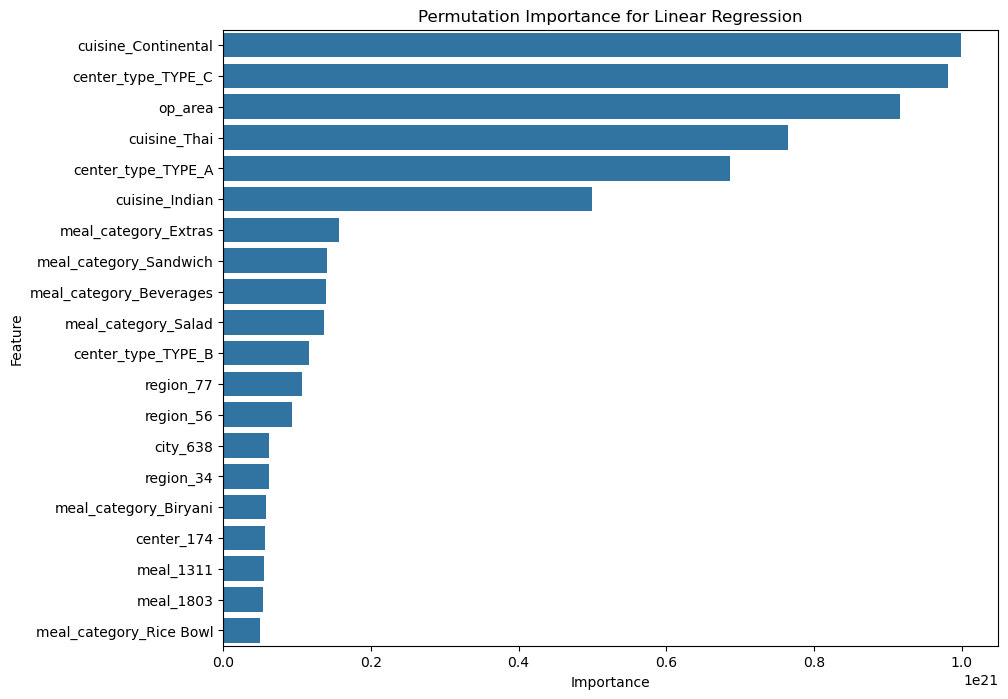

Evaluating Gradient Boosting...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=-1.421 total time= 1.8min
[CV 2/3] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=-1.417 total time= 1.8min
[CV 3/3] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=-1.415 total time= 1.9min
[CV 1/3] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200;, score=-1.168 total time= 3.7min
[CV 2/3] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200;, score=-1.171 total time= 3.7min
[CV 3/3] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200;, score=-1.167 total time= 3.6min
[CV 1/3] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=-1.206 total time= 2.9min
[CV 2/3] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=10

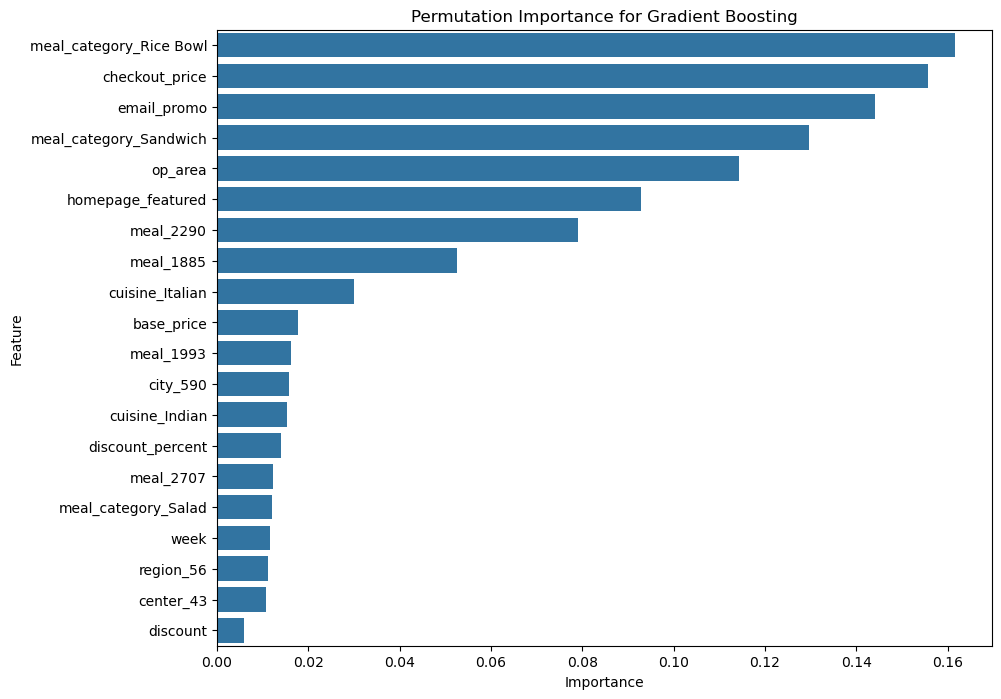

Evaluating XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=-1.423 total time=   1.5s
[CV 2/3] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=-1.418 total time=   1.4s
[CV 3/3] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=-1.417 total time=   1.5s
[CV 1/3] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200;, score=-1.171 total time=   2.1s
[CV 2/3] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200;, score=-1.172 total time=   2.1s
[CV 3/3] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200;, score=-1.169 total time=   2.3s
[CV 1/3] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=-1.209 total time=   1.7s
[CV 2/3] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=

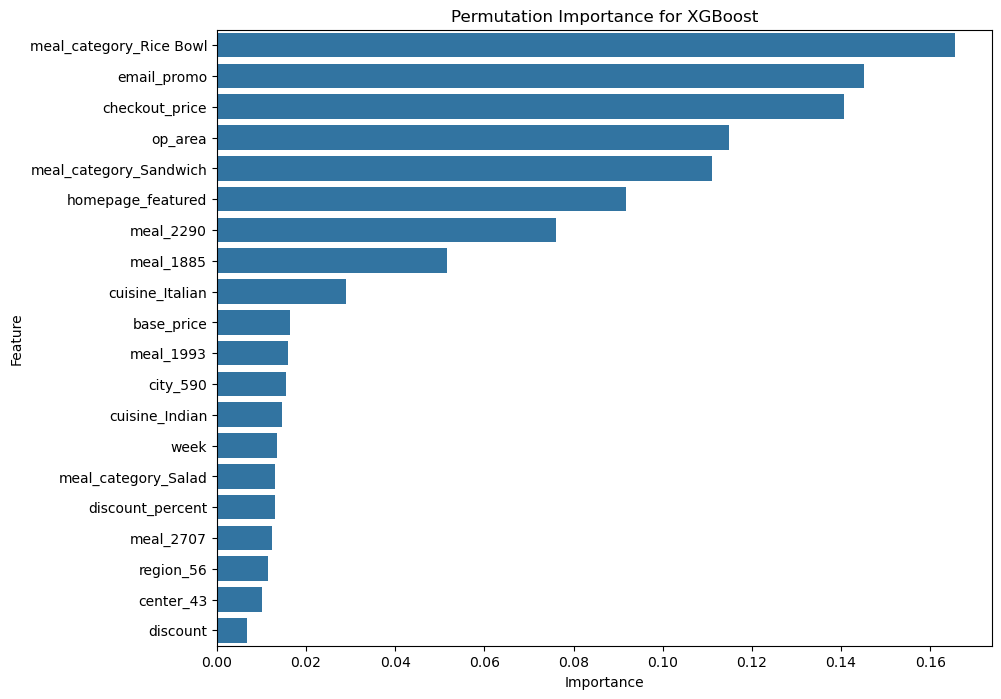

Evaluating Decision Tree...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END model__max_depth=3, model__min_samples_split=2;, score=-1.238 total time=   1.5s
[CV 2/3] END model__max_depth=3, model__min_samples_split=2;, score=-1.245 total time=   1.5s
[CV 3/3] END model__max_depth=3, model__min_samples_split=2;, score=-1.235 total time=   1.7s
[CV 1/3] END model__max_depth=3, model__min_samples_split=10;, score=-1.238 total time=   1.5s
[CV 2/3] END model__max_depth=3, model__min_samples_split=10;, score=-1.245 total time=   1.6s
[CV 3/3] END model__max_depth=3, model__min_samples_split=10;, score=-1.235 total time=   1.5s
[CV 1/3] END model__max_depth=3, model__min_samples_split=20;, score=-1.238 total time=   1.6s
[CV 2/3] END model__max_depth=3, model__min_samples_split=20;, score=-1.245 total time=   1.5s
[CV 3/3] END model__max_depth=3, model__min_samples_split=20;, score=-1.235 total time=   1.5s
[CV 1/3] END model__max_depth=5, model__min_samples_split=2;

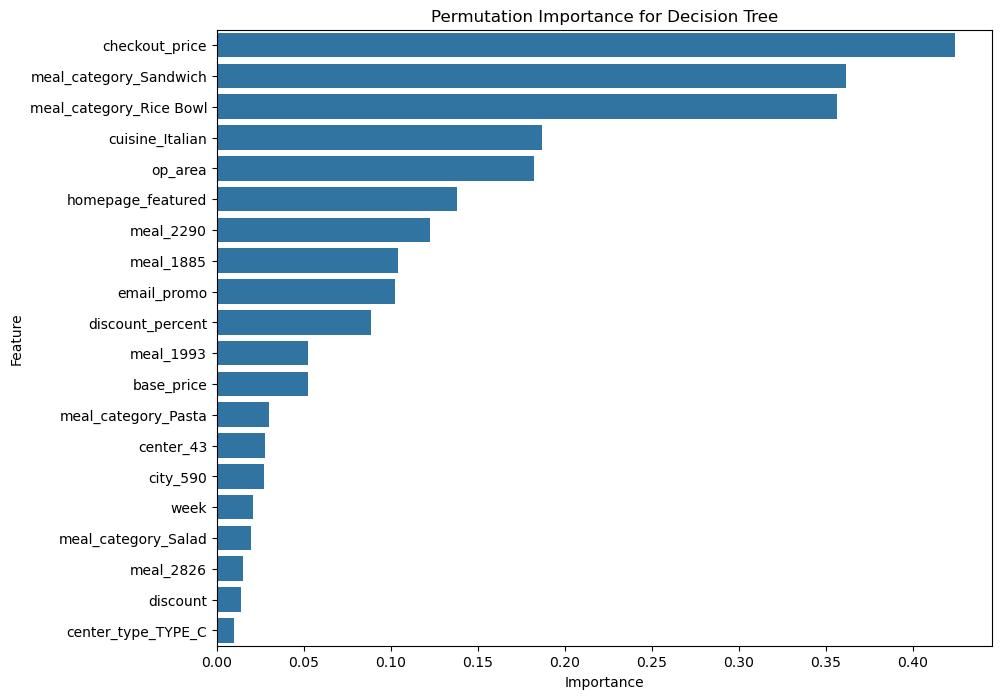

Evaluating Neural Network...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=adaptive, model__solver=adam;, score=nan total time= 3.0min
[CV 2/3] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=adaptive, model__solver=adam;, score=nan total time= 4.1min
[CV 3/3] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=adaptive, model__solver=adam;, score=nan total time= 3.6min
[CV 1/3] END model__activation=relu, model__alpha=0.05, model__hidden_layer_sizes=(50, 100, 50), model__learning_rate=constant, model__solver=sgd;, score=nan total time=10.0min
[CV 2/3] END model__activation=relu, model__alpha=0.05, model__hidden_layer_sizes=(50, 100, 50), model__learning_rate=constant, model__solver=sgd;, score=nan total time=10.0min
[CV 3/3] END model_

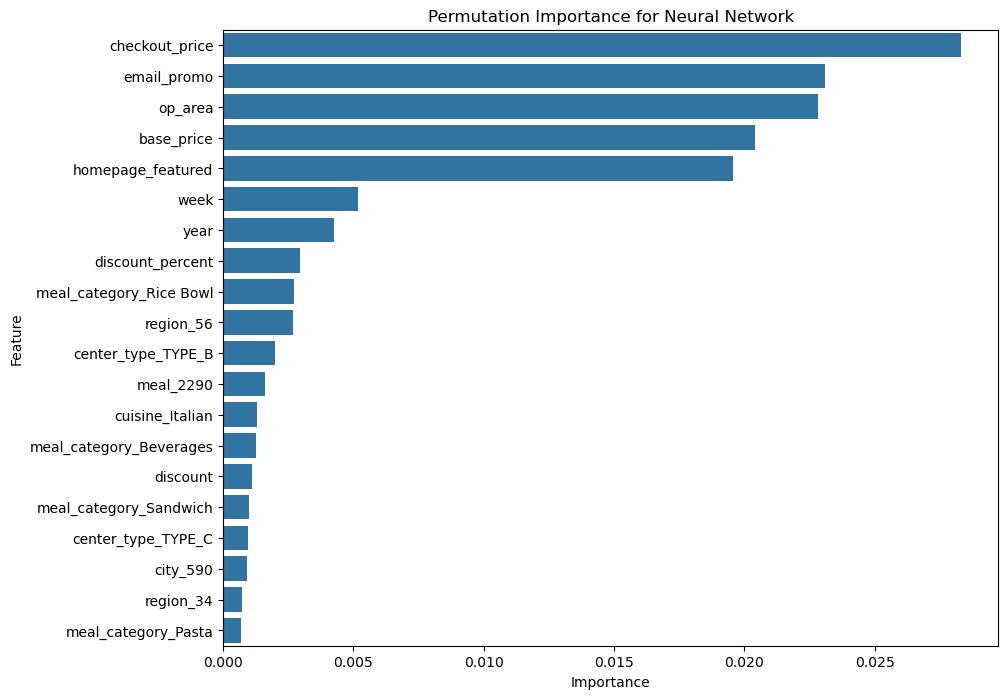

Evaluating Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END model__max_depth=3, model__min_samples_split=2, model__n_estimators=100;, score=-1.227 total time= 1.2min
[CV 2/3] END model__max_depth=3, model__min_samples_split=2, model__n_estimators=100;, score=-1.233 total time= 1.2min
[CV 3/3] END model__max_depth=3, model__min_samples_split=2, model__n_estimators=100;, score=-1.226 total time= 1.2min
[CV 1/3] END model__max_depth=3, model__min_samples_split=2, model__n_estimators=200;, score=-1.228 total time= 2.3min
[CV 2/3] END model__max_depth=3, model__min_samples_split=2, model__n_estimators=200;, score=-1.233 total time= 2.3min
[CV 3/3] END model__max_depth=3, model__min_samples_split=2, model__n_estimators=200;, score=-1.228 total time= 2.3min
[CV 1/3] END model__max_depth=5, model__min_samples_split=10, model__n_estimators=100;, score=-0.945 total time= 1.8min
[CV 2/3] END model__max_depth=5, model__min_samples_split=10, model__n_estima

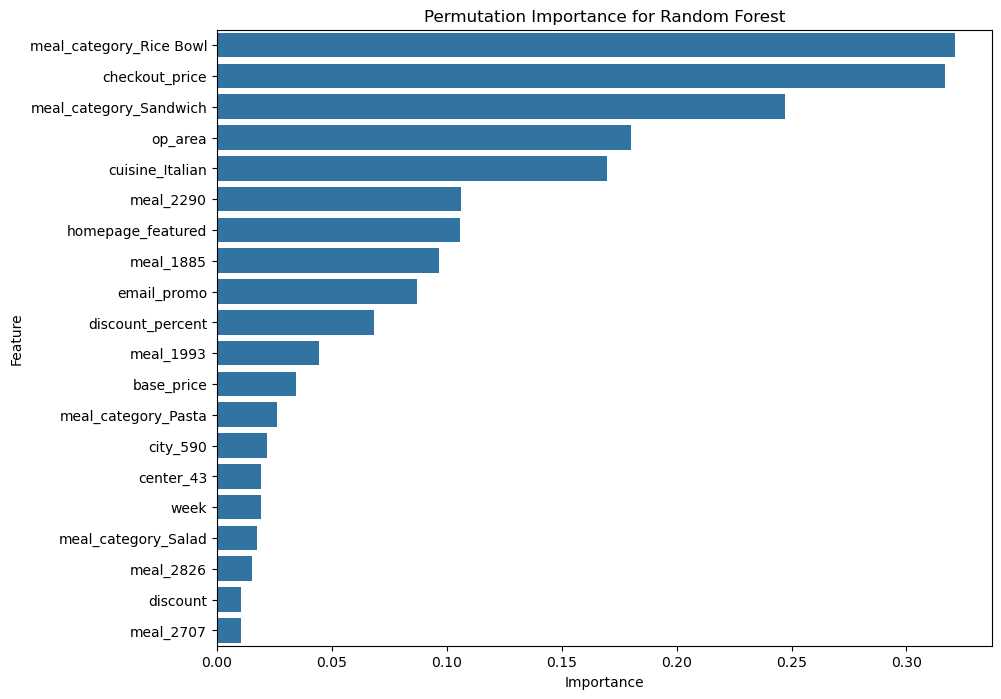

Time taken for Time Series XGBoost fitting: 0.04 minutes
Train RMSLE: 0.7007
Validation RMSLE: 0.8930
                     Feature  Importance
70   meal_category_Rice Bowl    0.270903
4                    op_area    0.199055
0             checkout_price    0.190394
72    meal_category_Sandwich    0.141511
9                email_promo    0.123633
33                 meal_1885    0.098237
41                 meal_2290    0.091023
10         homepage_featured    0.055174
1                 base_price    0.054180
78           cuisine_Italian    0.044613
57                 meal_2707    0.036649
2                   discount    0.030470
97                  city_590    0.024318
37                 meal_1993    0.022165
71       meal_category_Salad    0.020616
3           discount_percent    0.020428
77            cuisine_Indian    0.020087
119                 city_679    0.017069
134                region_56    0.015040
218       center_type_TYPE_C    0.009671


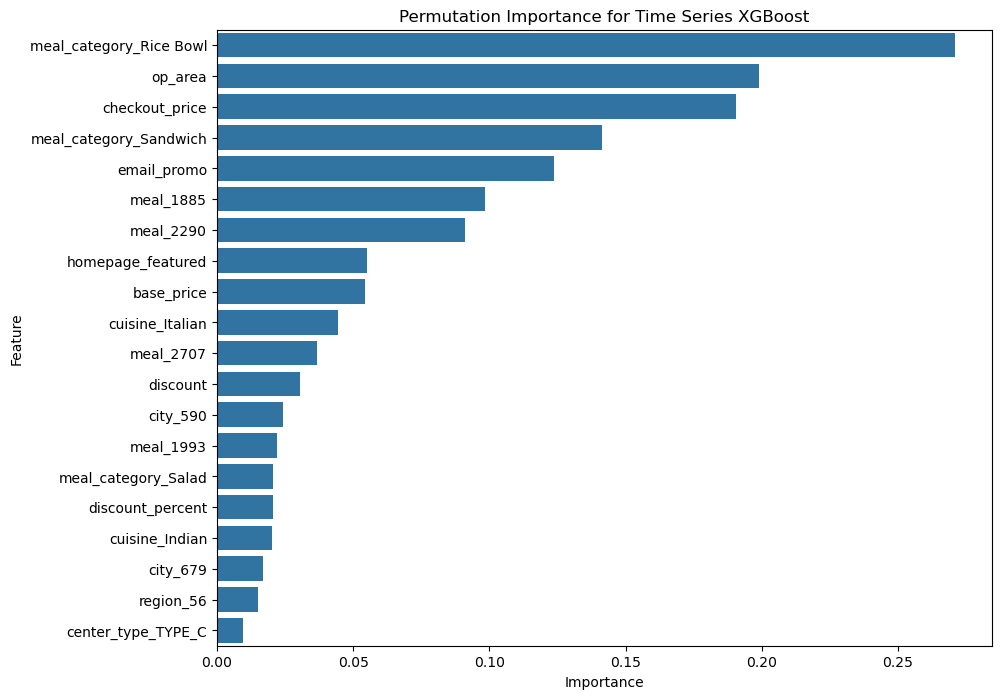

                 Model  Train RMSLE  Validation RMSLE  Grid Search Time (s)  \
0    Linear Regression   173.611188        174.600643                   NaN   
1    Gradient Boosting    95.601596         95.532223             95.492256   
2              XGBoost    95.710438         95.646339              0.864760   
3        Decision Tree    73.422443         73.554408              1.220898   
4       Neural Network   128.745502        128.859633            169.581293   
5        Random Forest    72.897735         73.059869            101.760949   
6  Time Series XGBoost    70.068281         89.304250                   NaN   

   Fit Time (s)                                        Best Params  
0      0.038482                                                N/A  
1      9.424380  {'memory': None, 'steps': [('preprocessor', Co...  
2      0.056290  {'memory': None, 'steps': [('preprocessor', Co...  
3      0.090258  {'memory': None, 'steps': [('preprocessor', Co...  
4      0.535214  {'mem

In [395]:
numerical_features = ['checkout_price', 'base_price', 'discount', 'discount_percent', 'op_area', 'week', 'year', 'quarter', 'month', 'email_promo', 'homepage_featured']
categorical_features = ['meal', 'meal_category', 'cuisine', 'city', 'region', 'center', 'center_type']

results_df, feature_importances = evaluate_models(df, 'num_orders', numerical_features, categorical_features)

In [402]:
joblib.dump(feature_importances, 'feature_importances.pkl')

['feature_importances.pkl']

In [224]:
results_df.to_csv('results.csv', index=False)

In [396]:
results_df.head(10)

,Model,Train RMSLE,Validation RMSLE,Grid Search Time (s),Fit Time (s),Best Params
0,Linear Regression,173.611188,174.600643,NaN,0.038482,N/A
1,Gradient Boosting,95.601596,95.532223,95.492256,9.424380,"{'memory': None, 'steps': [('preprocessor', Co..."
2,XGBoost,95.710438,95.646339,0.864760,0.056290,"{'memory': None, 'steps': [('preprocessor', Co..."
3,Decision Tree,73.422443,73.554408,1.220898,0.090258,"{'memory': None, 'steps': [('preprocessor', Co..."
4,Neural Network,128.745502,128.859633,169.581293,0.535214,"{'memory': None, 'steps': [('preprocessor', Co..."
5,Random Forest,72.897735,73.059869,101.760949,10.319966,"{'memory': None, 'steps': [('preprocessor', Co..."
6,Time Series XGBoost,70.068281,89.304250,NaN,0.036074,"{'memory': None, 'steps': [('preprocessor', Co..."


In [14]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Validation RMSLE", data=results_df)
plt.title('Validation RMSLE for Different Models')
for i in range(results_df.shape[0]):
    plt.text(i, results_df['Validation RMSLE'][i] - 0.1, f"Fit Time: {results_df['Fit Time (s)'][i]:.2f} min", ha = 'center')
plt.ylabel('Validation RMSLE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.savefig('images/validation_rmsle.png')
plt.show()

In [403]:
# Identify the best model based on validation RMSLE
best_model_name = results_df.loc[results_df['Validation RMSLE'].idxmin()]['Model']
print(f"Best Model: {best_model_name}")

Best Model: Random Forest


In [408]:
best_rf_params = {
    'model__n_estimators': 200,
    'model__min_samples_split': 2,
    'model__max_depth': 10
}

# Define the Random Forest model with the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=best_rf_params['model__n_estimators'],
    min_samples_split=best_rf_params['model__min_samples_split'],
    max_depth=best_rf_params['model__max_depth']
)

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', best_rf_model)])

# Use the existing train-test split
X = df.drop(columns=['num_orders'])
y = df['num_orders']


# Split the data again to get the test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
pipeline.fit(X_train, y_train)

joblib.dump(pipeline, 'Random_Forest_best_model.pkl')

['Random_Forest_best_model.pkl']

In [412]:
# Load the best model
best_model = joblib.load(f"Random_Forest_best_model.pkl")
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['checkout_price',
                                                   'base_price', 'discount',
                                                   'discount_percent',
                                                   'op_area', 'week', 'year',
                                                   'quarter', 'month',
                                                   'email_promo',
                                                   'homepage_featured']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['meal', 'meal_category',
                                                   'cuisine', 'city', 'region',
                                                   'center',
                                                   'center_type'])])),
                ('model',
                 RandomForestRegressor(max_depth=10, n_estimators=200))])

In [413]:
test_predictions = best_model.predict(X_test)
test_predictions = np.clip(test_predictions, 0, None)  # Clip to ensure non-negative predictions

# Compare predictions to actual values
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions})

# Calculate RMSLE on the test set
test_rmsle = np.sqrt(mean_squared_log_error(y_test, test_predictions))
print(f"Test RMSLE for {best_model_name}: {test_rmsle:.4f}")

Test RMSLE for Random Forest: 0.7352


In [417]:
# Optionally, save the comparison dataframe for further analysis
comparison_df.to_csv('actual_vs_predicted.csv', index=False)

        Actual   Predicted
426106     108  118.786833
437739     134   54.035360
41409      163  278.717094
305350     229  294.031345
306987      13   27.529399
241270     175  487.666413
211565      67   94.083848
357830     500  432.075890
358150     312   94.083848
197266      68   54.035360


In [430]:
print(comparison_df.head(20).round(2))

        Actual  Predicted
426106     108     118.79
437739     134      54.04
41409      163     278.72
305350     229     294.03
306987      13      27.53
241270     175     487.67
211565      67      94.08
357830     500     432.08
358150     312      94.08
197266      68      54.04
419232     177      94.08
336833      27      94.08
35760       95     289.60
29133       96      94.08
43443      150     171.23
348047     107     294.03
85068       15      27.53
141814      94      54.04
355276      96      94.08
61384       67      75.99


##  <font color= darkred> Final Evaluation on the Test Set </font>

In [424]:
# Append test results to the results dataframe
test_results = {
    "Model": f"{best_model_name} (Test Set)",
    "Train RMSLE": None,
    "Validation RMSLE": None,
    "Grid Search Time (s)": None,
    "Fit Time (s)": None,
    "Best Params": None,
    "Test RMSLE": 100 * test_rmsle
}
test_results_df = pd.DataFrame([test_results])  # Convert test_results to DataFrame

if isinstance(results_df, pd.DataFrame):
    results_df = pd.concat([results_df, test_results_df], ignore_index=True)
else:
    print("results_df is not a DataFrame. Please check its initialization.")

results_df.to_csv('model_results_with_test.csv', index=False)
print(results_df)

                      Model  Train RMSLE  Validation RMSLE  \
0         Linear Regression   173.611188        174.600643   
1         Gradient Boosting    95.601596         95.532223   
2                   XGBoost    95.710438         95.646339   
3             Decision Tree    73.422443         73.554408   
4            Neural Network   128.745502        128.859633   
5             Random Forest    72.897735         73.059869   
6       Time Series XGBoost    70.068281         89.304250   
7  Random Forest (Test Set)          NaN               NaN   
8  Random Forest (Test Set)          NaN               NaN   

   Grid Search Time (s)  Fit Time (s)  \
0                   NaN      0.038482   
1             95.492256      9.424380   
2              0.864760      0.056290   
3              1.220898      0.090258   
4            169.581293      0.535214   
5            101.760949     10.319966   
6                   NaN      0.036074   
7                   NaN           NaN   
8         

In [421]:
print(type(results_df))

<class 'pandas.core.frame.DataFrame'>


### Bar Plot of RMSLE for All Models

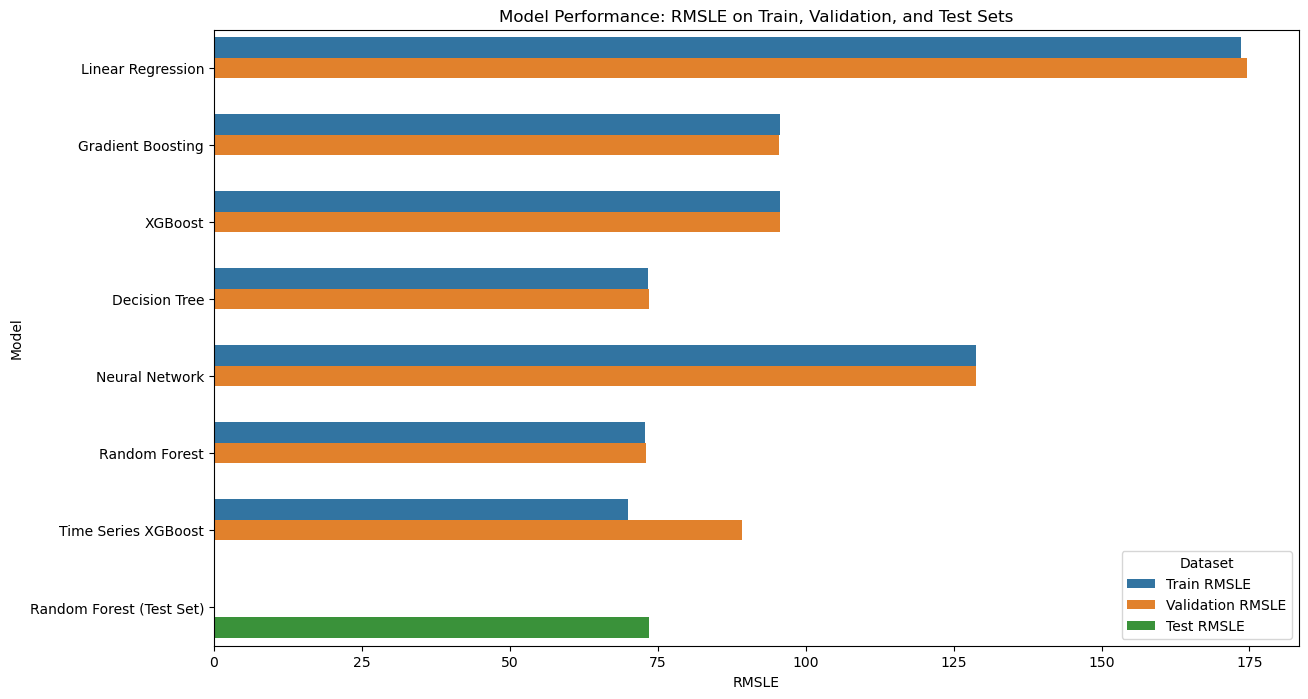

In [425]:
results_df = pd.read_csv('model_results_with_test.csv')

# Melt the dataframe to long format for easier plotting with seaborn
melted_results_df = results_df.melt(id_vars=['Model'], value_vars=['Train RMSLE', 'Validation RMSLE', 'Test RMSLE'],
                                    var_name='Set', value_name='RMSLE')

# Plot the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='RMSLE', y='Model', hue='Set', data=melted_results_df)
plt.title('Model Performance: RMSLE on Train, Validation, and Test Sets')
plt.xlabel('RMSLE')
plt.ylabel('Model')
plt.legend(title='Dataset')
plt.show()

## Prediction vs Actual Plot

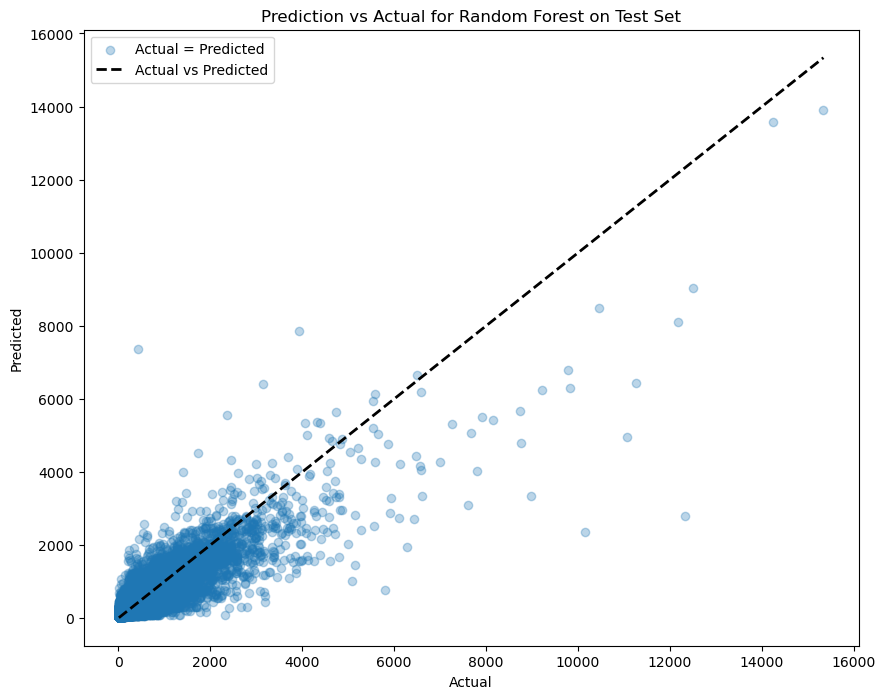

In [415]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 8))
plt.scatter(comparison_df['Actual'], comparison_df['Predicted'], alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.legend(['Actual = Predicted', 'Actual vs Predicted'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Prediction vs Actual for {best_model_name} on Test Set')
plt.show()